# Seasonal Analysis Per Product - Everbee Shop

## Objective
This notebook performs detailed seasonal analysis for each product to identify:
- **Best/Worst Months**: When each product performs best
- **Seasonal Patterns**: Which products are seasonal vs year-round
- **Growth Trends**: Products with increasing/decreasing seasonal trends
- **Launch Timing**: Optimal months to launch new products
- **Product-Specific Insights**: Customized seasonal strategies per product

## Data Source
- `json_files_total_reviewrs/` - Products ranked by reviewers
- `json_files_total_sales/` - Products ranked by sales


In [59]:
# Import libraries
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Any, Optional
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Step 1: Load All JSON Files


In [60]:
# Load all JSON files
folder_reviewrs = 'json_files_total_reviewrs'
folder_sales = 'json_files_total_sales'

json_files_reviewrs = []
json_files_sales = []

if os.path.exists(folder_reviewrs):
    json_files_reviewrs = [f for f in os.listdir(folder_reviewrs) if f.endswith('.json')]
    print(f"✓ Found {len(json_files_reviewrs)} files in {folder_reviewrs}/")

if os.path.exists(folder_sales):
    json_files_sales = [f for f in os.listdir(folder_sales) if f.endswith('.json')]
    print(f"✓ Found {len(json_files_sales)} files in {folder_sales}/")

total_files = len(json_files_reviewrs) + len(json_files_sales)
print(f"\n📊 Total JSON files to process: {total_files}")


✓ Found 29 files in json_files_total_reviewrs/
✓ Found 1 files in json_files_total_sales/

📊 Total JSON files to process: 30


## Step 2: Extract Product Information and Seasonal Trends


In [61]:
def extract_product_seasonal_data(file_path: str, folder_type: str) -> Dict[str, Any]:
    """
    Extract product information and seasonal trends from JSON file.
    Returns both product info and seasonal trends.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        listing = data.get('listing', {})
        listing_id = listing.get('listing_id')
        title = listing.get('title')
        price = float(listing.get('price', 0) or 0)
        sales = int(listing.get('transaction_sold_count', 0) or 0)
        revenue = price * sales
        
        # Extract trends
        trends = listing.get('trends', [])
        trends_list = []
        
        for trend_data in trends:
            try:
                date_str = trend_data.get('date')
                if not date_str:
                    continue
                
                date = pd.to_datetime(date_str, errors='coerce')
                if pd.isna(date):
                    continue
                
                trend = {
                    'listing_id': listing_id,
                    'title': title,
                    'date': date,
                    'year': date.year,
                    'month': date.month,
                    'month_name': date.strftime('%B'),
                    'quarter': f"Q{(date.month-1)//3 + 1}",
                    'season': 'Spring' if date.month in [3,4,5] else 
                             'Summer' if date.month in [6,7,8] else
                             'Fall' if date.month in [9,10,11] else 'Winter',
                    'total_sales': int(trend_data.get('total_sales', 0) or 0),
                    'total_revenue': float(trend_data.get('total_revenue', 0) or 0),
                    'product_price': price,
                    'product_total_sales': sales,
                    'product_total_revenue': revenue,
                    'folder_source': folder_type,
                }
                trends_list.append(trend)
            except Exception:
                continue
        
        return {
            'product_info': {
                'listing_id': listing_id,
                'title': title,
                'price': price,
                'total_sales': sales,
                'total_revenue': revenue,
                'folder_source': folder_type,
            },
            'trends': trends_list
        }
    except Exception as e:
        return {'product_info': None, 'trends': []}

print("✓ Extraction function created")


✓ Extraction function created


In [62]:
# Extract all data
all_products_info = []
all_trends = []

print("Processing reviewrs folder...")
for filename in json_files_reviewrs:
    file_path = os.path.join(folder_reviewrs, filename)
    data = extract_product_seasonal_data(file_path, 'reviewrs')
    if data['product_info']:
        all_products_info.append(data['product_info'])
    all_trends.extend(data['trends'])

print(f"✓ Processed {len(json_files_reviewrs)} files from reviewrs")

print("\nProcessing sales folder...")
for filename in json_files_sales:
    file_path = os.path.join(folder_sales, filename)
    data = extract_product_seasonal_data(file_path, 'sales')
    if data['product_info']:
        all_products_info.append(data['product_info'])
    all_trends.extend(data['trends'])

print(f"✓ Processed {len(json_files_sales)} files from sales")

# Create DataFrames
products_df = pd.DataFrame(all_products_info)

if all_trends:
    trends_df = pd.DataFrame(all_trends)
    trends_df['date'] = pd.to_datetime(trends_df['date'])
    print(f"\n✓ Extracted {len(trends_df)} seasonal trend records")
    print(f"  - Unique products: {trends_df['listing_id'].nunique()}")
    print(f"  - Date range: {trends_df['date'].min().strftime('%Y-%m-%d')} to {trends_df['date'].max().strftime('%Y-%m-%d')}")
else:
    trends_df = pd.DataFrame()
    print("\n⚠ No seasonal trends data found")

print(f"\n✓ Total products: {len(products_df)}")


Processing reviewrs folder...
✓ Processed 29 files from reviewrs

Processing sales folder...
✓ Processed 1 files from sales

✓ Extracted 785 seasonal trend records
  - Unique products: 29
  - Date range: 2023-03-01 to 2025-09-01

✓ Total products: 30


## Step 3: Product-Level Seasonal Analysis


In [63]:
if len(trends_df) > 0:
    # Calculate seasonal metrics for each product
    product_seasonal_analysis = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = products_df[products_df['listing_id'] == listing_id].iloc[0]
        
        # Monthly analysis
        monthly_stats = product_trends.groupby('month').agg({
            'total_revenue': 'sum',
            'total_sales': 'sum'
        }).reset_index()
        
        best_month = monthly_stats.loc[monthly_stats['total_revenue'].idxmax()]
        worst_month = monthly_stats.loc[monthly_stats['total_revenue'].idxmin()]
        
        # Seasonal analysis
        seasonal_stats = product_trends.groupby('season').agg({
            'total_revenue': 'sum',
            'total_sales': 'sum'
        }).reset_index()
        
        best_season = seasonal_stats.loc[seasonal_stats['total_revenue'].idxmax()]
        worst_season = seasonal_stats.loc[seasonal_stats['total_revenue'].idxmin()]
        
        # Calculate seasonal variation (coefficient of variation)
        monthly_revenue_std = monthly_stats['total_revenue'].std()
        monthly_revenue_mean = monthly_stats['total_revenue'].mean()
        seasonal_variation = (monthly_revenue_std / monthly_revenue_mean * 100) if monthly_revenue_mean > 0 else 0
        
        # Determine if product is seasonal (high variation) or stable (low variation)
        is_seasonal = seasonal_variation > 30  # Threshold: >30% variation indicates seasonality
        
        # Calculate growth trend (comparing first half vs second half of data)
        sorted_trends = product_trends.sort_values('date')
        mid_point = len(sorted_trends) // 2
        first_half_revenue = sorted_trends.iloc[:mid_point]['total_revenue'].sum()
        second_half_revenue = sorted_trends.iloc[mid_point:]['total_revenue'].sum()
        growth_rate = ((second_half_revenue - first_half_revenue) / first_half_revenue * 100) if first_half_revenue > 0 else 0
        
        product_analysis = {
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': product_info['total_revenue'],
            'total_sales': product_info['total_sales'],
            'price': product_info['price'],
            'best_month': best_month['month'],
            'best_month_revenue': best_month['total_revenue'],
            'worst_month': worst_month['month'],
            'worst_month_revenue': worst_month['total_revenue'],
            'best_season': best_season['season'],
            'best_season_revenue': best_season['total_revenue'],
            'worst_season': worst_season['season'],
            'worst_season_revenue': worst_season['total_revenue'],
            'seasonal_variation': seasonal_variation,
            'is_seasonal': is_seasonal,
            'growth_rate': growth_rate,
            'trend_records': len(product_trends),
            'months_covered': product_trends['month'].nunique(),
        }
        
        product_seasonal_analysis.append(product_analysis)
    
    # Create analysis DataFrame
    seasonal_analysis_df = pd.DataFrame(product_seasonal_analysis)
    
    print(f"✓ Seasonal analysis completed for {len(seasonal_analysis_df)} products")
    print(f"\n📊 Summary:")
    print(f"  • Seasonal products (variation > 30%): {len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == True])}")
    print(f"  • Stable products (variation ≤ 30%): {len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == False])}")
    print(f"  • Growing products (positive growth): {len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0])}")
    print(f"  • Declining products (negative growth): {len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] < 0])}")
else:
    seasonal_analysis_df = pd.DataFrame()
    print("⚠ No seasonal data available for analysis")


✓ Seasonal analysis completed for 29 products

📊 Summary:
  • Seasonal products (variation > 30%): 29
  • Stable products (variation ≤ 30%): 0
  • Growing products (positive growth): 3
  • Declining products (negative growth): 26


In [64]:
# Export seasonal analysis
if len(seasonal_analysis_df) > 0:
    seasonal_analysis_df.to_csv('product_seasonal_analysis.csv', index=False, encoding='utf-8')
    print("✓ Exported: product_seasonal_analysis.csv")
    
    # Export detailed trends
    trends_df.to_csv('product_seasonal_trends_detailed.csv', index=False, encoding='utf-8')
    print("✓ Exported: product_seasonal_trends_detailed.csv")
    
    print("\n" + "="*70)
    print("PRODUCT SEASONAL ANALYSIS SUMMARY")
    print("="*70)
    
    # Top seasonal products
    top_seasonal = seasonal_analysis_df.nlargest(10, 'seasonal_variation')
    print(f"\n📈 TOP 10 MOST SEASONAL PRODUCTS (Highest Variation):")
    for idx, row in top_seasonal.iterrows():
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        print(f"  • {row['title'][:60]}")
        print(f"    Variation: {row['seasonal_variation']:.1f}% | Best Month: {month_names[int(row['best_month'])-1]} | Best Season: {row['best_season']}")
    
    print(f"\n💡 Insight: These products show strong seasonal patterns - plan inventory and marketing accordingly")


✓ Exported: product_seasonal_analysis.csv
✓ Exported: product_seasonal_trends_detailed.csv

PRODUCT SEASONAL ANALYSIS SUMMARY

📈 TOP 10 MOST SEASONAL PRODUCTS (Highest Variation):
  • Reading Log Chart - PRINTABLE Journal Page - Planner Page - 
    Variation: 159.9% | Best Month: Dec | Best Season: Winter
  • Stress Tracker - PRINTABLE Journal Page - Habit Tracker - An
    Variation: 150.4% | Best Month: Dec | Best Season: Winter
  • Sleep Tracker Yearly - PRINTABLE Journal Page - Planner Page
    Variation: 136.8% | Best Month: Dec | Best Season: Winter
  • Shower Tracker - PRINTABLE Journal Page - Planner Page - Dai
    Variation: 136.2% | Best Month: Dec | Best Season: Winter
  • Water Tracker Yearly - PRINTABLE Journal Page - Planner Page
    Variation: 133.1% | Best Month: Dec | Best Season: Winter
  • Step Tracker Yearly - PRINTABLE Journal Page - Planner Page 
    Variation: 131.3% | Best Month: Dec | Best Season: Winter
  • Gratitude Journal - PRINTABLE Journal Page - Gratitude

In [65]:
if len(seasonal_analysis_df) > 0:
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print("="*70)
    print("BEST/WORST MONTHS PER PRODUCT")
    print("="*70)
    
    # Products sorted by total revenue
    top_products = seasonal_analysis_df.nlargest(15, 'total_revenue')
    
    print(f"\n📊 TOP 15 PRODUCTS - Best/Worst Months:")
    print("-" * 70)
    for idx, row in top_products.iterrows():
        best_month_name = month_names[int(row['best_month'])-1]
        worst_month_name = month_names[int(row['worst_month'])-1]
        print(f"\n{idx+1}. {row['title'][:55]}")
        print(f"   Best Month: {best_month_name} (${row['best_month_revenue']:,.2f})")
        print(f"   Worst Month: {worst_month_name} (${row['worst_month_revenue']:,.2f})")
        print(f"   Variation: {row['seasonal_variation']:.1f}% | {'Seasonal' if row['is_seasonal'] else 'Stable'}")
    
    # Count products by best month
    best_month_distribution = seasonal_analysis_df['best_month'].value_counts().sort_index()
    print(f"\n📅 PRODUCT DISTRIBUTION BY BEST MONTH:")
    print("-" * 70)
    for month_num, count in best_month_distribution.items():
        print(f"  {month_names[int(month_num)-1]}: {count} products peak in this month")
    
    print(f"\n💡 Insight: {best_month_distribution.idxmax()} ({month_names[int(best_month_distribution.idxmax())-1]}) is the most common peak month")
    print(f"   Consider this when planning product launches and marketing campaigns")


BEST/WORST MONTHS PER PRODUCT

📊 TOP 15 PRODUCTS - Best/Worst Months:
----------------------------------------------------------------------

8. Guess Who Mommy or Daddy Game Baby Shower Party Game Mo
   Best Month: Jul ($1,291.05)
   Worst Month: Feb ($270.75)
   Variation: 46.2% | Seasonal

17. Saveopoly Savings Challenge - PRINTABLE Journal Page - 
   Best Month: Dec ($6,101.81)
   Worst Month: May ($92.82)
   Variation: 112.8% | Seasonal

23. Swatch Test - PRINTABLE Journal Page - Planner Page - C
   Best Month: Dec ($713.55)
   Worst Month: Feb ($38.34)
   Variation: 70.9% | Seasonal

1. 24 Hour Sleep Tracker - PRINTABLE Journal Page - Monthl
   Best Month: Dec ($643.50)
   Worst Month: Mar ($84.00)
   Variation: 66.6% | Seasonal

2. Adulting Tracker - PRINTABLE Journal Page - Monthly Tra
   Best Month: Dec ($1,947.00)
   Worst Month: Jun ($105.00)
   Variation: 108.8% | Seasonal

3. Anxiety Tracker - PRINTABLE Journal Page - Anxiety Log 
   Best Month: Dec ($1,009.50)
   Worst Mo

## Step 5: Seasonal vs Stable Products Analysis


In [66]:
if len(seasonal_analysis_df) > 0:
    print("="*70)
    print("SEASONAL vs STABLE PRODUCTS")
    print("="*70)
    
    seasonal_products = seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == True]
    stable_products = seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == False]
    
    print(f"\n📈 SEASONAL PRODUCTS ({len(seasonal_products)} products):")
    print(f"  • Average Variation: {seasonal_products['seasonal_variation'].mean():.1f}%")
    print(f"  • Average Revenue: ${seasonal_products['total_revenue'].mean():,.2f}")
    print(f"  • Total Revenue: ${seasonal_products['total_revenue'].sum():,.2f}")
    print(f"\n  Top 5 Seasonal Products:")
    for idx, row in seasonal_products.nlargest(5, 'total_revenue').iterrows():
        print(f"    • {row['title'][:55]}")
        print(f"      Revenue: ${row['total_revenue']:,.2f} | Variation: {row['seasonal_variation']:.1f}% | Best: {row['best_season']}")
    
    print(f"\n📊 STABLE PRODUCTS ({len(stable_products)} products):")
    print(f"  • Average Variation: {stable_products['seasonal_variation'].mean():.1f}%")
    print(f"  • Average Revenue: ${stable_products['total_revenue'].mean():,.2f}")
    print(f"  • Total Revenue: ${stable_products['total_revenue'].sum():,.2f}")
    print(f"\n  Top 5 Stable Products:")
    for idx, row in stable_products.nlargest(5, 'total_revenue').iterrows():
        print(f"    • {row['title'][:55]}")
        print(f"      Revenue: ${row['total_revenue']:,.2f} | Variation: {row['seasonal_variation']:.1f}%")
    
    print(f"\n💡 Insight: Seasonal products require inventory planning around peak seasons")
    print(f"   Stable products can maintain consistent inventory levels year-round")


SEASONAL vs STABLE PRODUCTS

📈 SEASONAL PRODUCTS (29 products):
  • Average Variation: 109.5%
  • Average Revenue: $512,061.17
  • Total Revenue: $14,849,773.93

  Top 5 Seasonal Products:
    • Guess Who Mommy or Daddy Game Baby Shower Party Game Mo
      Revenue: $927,207.60 | Variation: 46.2% | Best: Summer
    • Saveopoly Savings Challenge - PRINTABLE Journal Page - 
      Revenue: $718,981.51 | Variation: 112.8% | Best: Winter
    • Swatch Test - PRINTABLE Journal Page - Planner Page - C
      Revenue: $692,965.68 | Variation: 70.9% | Best: Fall
    • 24 Hour Sleep Tracker - PRINTABLE Journal Page - Monthl
      Revenue: $488,004.00 | Variation: 66.6% | Best: Fall
    • Adulting Tracker - PRINTABLE Journal Page - Monthly Tra
      Revenue: $488,004.00 | Variation: 108.8% | Best: Winter

📊 STABLE PRODUCTS (0 products):
  • Average Variation: nan%
  • Average Revenue: $nan
  • Total Revenue: $0.00

  Top 5 Stable Products:

💡 Insight: Seasonal products require inventory planning aro

## Step 6: Growth Trends Analysis


In [67]:
if len(seasonal_analysis_df) > 0:
    print("="*70)
    print("GROWTH TRENDS ANALYSIS")
    print("="*70)
    
    growing_products = seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0].sort_values('growth_rate', ascending=False)
    declining_products = seasonal_analysis_df[seasonal_analysis_df['growth_rate'] < 0].sort_values('growth_rate', ascending=True)
    stable_growth = seasonal_analysis_df[abs(seasonal_analysis_df['growth_rate']) <= 5]
    
    print(f"\n📈 GROWING PRODUCTS ({len(growing_products)} products with positive growth):")
    print(f"  • Average Growth Rate: {growing_products['growth_rate'].mean():.1f}%")
    print(f"  • Top 5 Fastest Growing:")
    for idx, row in growing_products.head(5).iterrows():
        print(f"    • {row['title'][:55]}")
        print(f"      Growth: {row['growth_rate']:.1f}% | Revenue: ${row['total_revenue']:,.2f}")
    
    print(f"\n📉 DECLINING PRODUCTS ({len(declining_products)} products with negative growth):")
    print(f"  • Average Decline Rate: {declining_products['growth_rate'].mean():.1f}%")
    if len(declining_products) > 0:
        print(f"  • Top 5 Most Declining:")
        for idx, row in declining_products.head(5).iterrows():
            print(f"    • {row['title'][:55]}")
            print(f"      Decline: {row['growth_rate']:.1f}% | Revenue: ${row['total_revenue']:,.2f}")
    
    print(f"\n➡️ STABLE GROWTH ({len(stable_growth)} products with minimal change):")
    print(f"  • These products maintain consistent performance")
    
    print(f"\n💡 Insight: Focus marketing efforts on growing products")
    print(f"   Investigate declining products for optimization opportunities")


GROWTH TRENDS ANALYSIS

📈 GROWING PRODUCTS (3 products with positive growth):
  • Average Growth Rate: 64.5%
  • Top 5 Fastest Growing:
    • Printable Birthday Card Floral Birthday Card Flower Bir
      Growth: 155.8% | Revenue: $322,082.64
    • Marker Tracker - PRINTABLE Journal Page - Planner Page 
      Growth: 28.2% | Revenue: $484,878.00
    • Book Tracker - PRINTABLE Journal Page - Book Journal - 
      Growth: 9.7% | Revenue: $488,004.00

📉 DECLINING PRODUCTS (26 products with negative growth):
  • Average Decline Rate: -47.4%
  • Top 5 Most Declining:
    • Habit Tracker - PRINTABLE Journal Page - Monthly Tracke
      Decline: -91.3% | Revenue: $488,004.00
    • Wheel of Habits - Habit Tracker - PRINTABLE Journal Pag
      Decline: -83.7% | Revenue: $488,004.00
    • Sleep Tracker - PRINTABLE Journal Page - Monthly Sleep 
      Decline: -82.6% | Revenue: $488,004.00
    • Stress Tracker - PRINTABLE Journal Page - Habit Tracker
      Decline: -74.4% | Revenue: $488,004.00
    

## Step 7: Visualizations - Product Seasonal Patterns


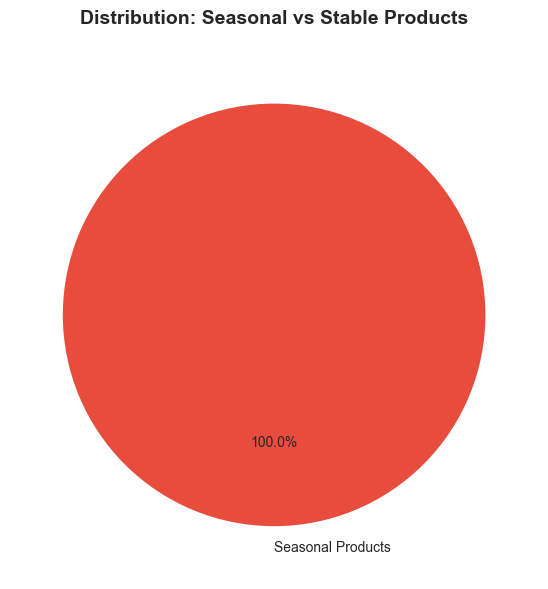

📊 Chart shows: Proportion of seasonal vs stable products
   Insight: 29 products (100.0%) are seasonal
            0 products (0.0%) are stable
   Seasonal products need different inventory and marketing strategies


In [68]:
if len(trends_df) > 0 and len(seasonal_analysis_df) > 0:
    # Visualization 1: Seasonal vs Stable Products Distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    seasonal_counts = seasonal_analysis_df['is_seasonal'].value_counts()
    
    # Create labels and colors dynamically based on what's in the data
    labels = []
    colors_list = []
    values = []
    
    if True in seasonal_counts.index:
        labels.append('Seasonal Products')
        colors_list.append('#e74c3c')
        values.append(seasonal_counts[True])
    
    if False in seasonal_counts.index:
        labels.append('Stable Products')
        colors_list.append('#3498db')
        values.append(seasonal_counts[False])
    
    if len(values) > 0:
        ax.pie(values, labels=labels, autopct='%1.1f%%', colors=colors_list, startangle=90)
        ax.set_title('Distribution: Seasonal vs Stable Products', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        seasonal_count = len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal']==True])
        stable_count = len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal']==False])
        print("📊 Chart shows: Proportion of seasonal vs stable products")
        print(f"   Insight: {seasonal_count} products ({seasonal_count/len(seasonal_analysis_df)*100:.1f}%) are seasonal")
        print(f"            {stable_count} products ({stable_count/len(seasonal_analysis_df)*100:.1f}%) are stable")
        print("   Seasonal products need different inventory and marketing strategies")
    else:
        print("⚠ No seasonal classification data available")
else:
    print("⚠ No data available for visualization")


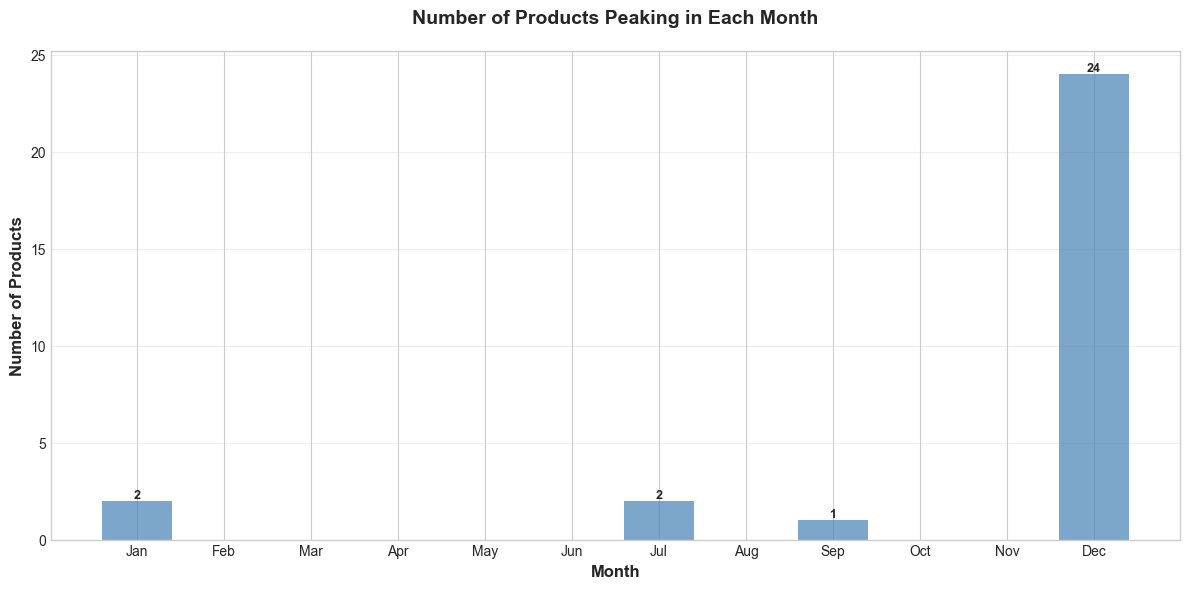

📊 Chart shows: Which months are peak months for most products
   Insight: Dec is the most common peak month (24 products)
   Plan product launches and marketing campaigns around peak months


In [69]:
if len(seasonal_analysis_df) > 0:
    # Visualization 2: Best Month Distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    best_month_counts = seasonal_analysis_df['best_month'].value_counts().sort_index()
    bars = ax.bar(range(1, 13), [best_month_counts.get(i, 0) for i in range(1, 13)], color='steelblue', alpha=0.7)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
    ax.set_title('Number of Products Peaking in Each Month', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, month in enumerate(range(1, 13)):
        count = best_month_counts.get(month, 0)
        if count > 0:
            ax.text(i+1, count, str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    best_month = best_month_counts.idxmax()
    print(f"📊 Chart shows: Which months are peak months for most products")
    print(f"   Insight: {month_names[int(best_month)-1]} is the most common peak month ({best_month_counts[best_month]} products)")
    print("   Plan product launches and marketing campaigns around peak months")
else:
    print("⚠ No data available for visualization")


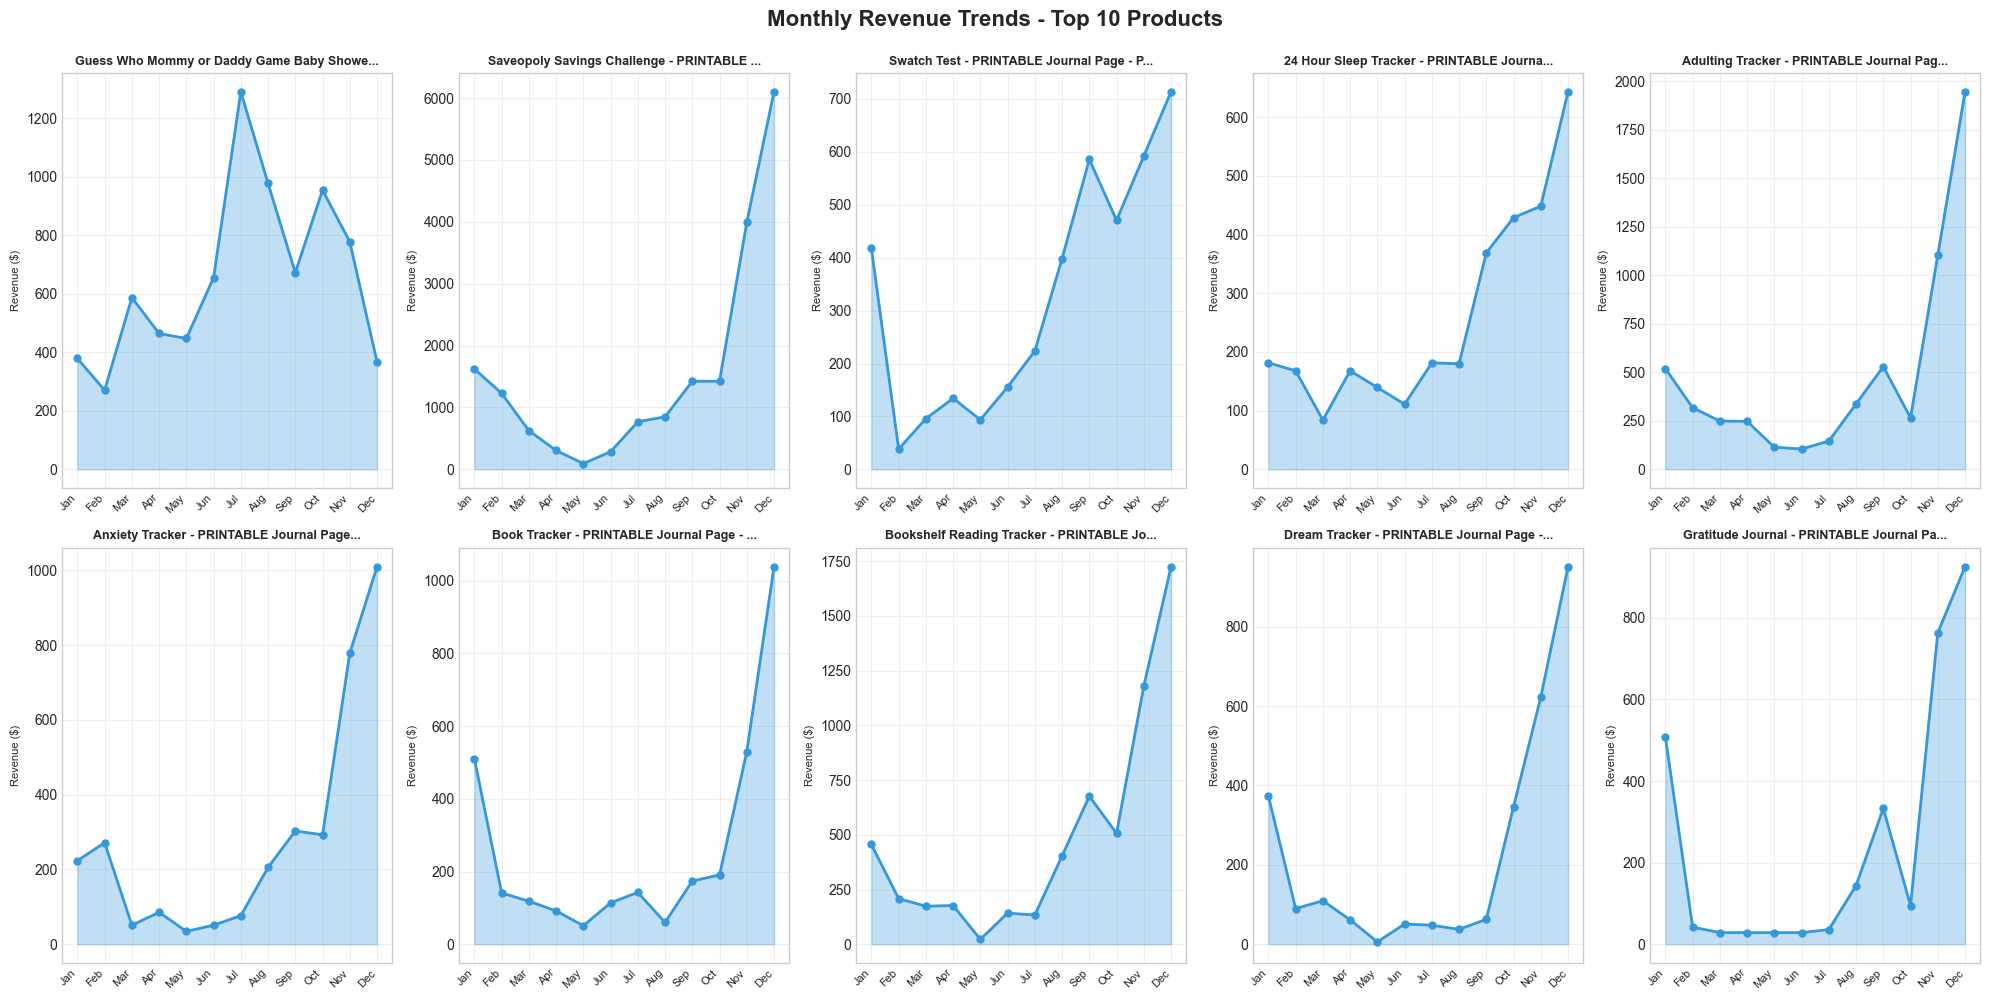

📊 Chart shows: Monthly revenue patterns for top 10 products
   Insight: Each product has unique seasonal patterns
   Use these patterns to optimize inventory and marketing timing


In [70]:
if len(trends_df) > 0:
    # Visualization 3: Top 10 Products - Monthly Revenue Trends
    top_10_products = seasonal_analysis_df.nlargest(10, 'total_revenue')
    top_10_ids = top_10_products['listing_id'].values
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for idx, listing_id in enumerate(top_10_ids):
        if idx >= 10:
            break
        
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_title = product_trends['title'].iloc[0]
        
        monthly_revenue = product_trends.groupby('month')['total_revenue'].sum().sort_index()
        
        ax = axes[idx]
        ax.plot(monthly_revenue.index, monthly_revenue.values, marker='o', linewidth=2, markersize=5, color='#3498db')
        ax.fill_between(monthly_revenue.index, monthly_revenue.values, alpha=0.3, color='#3498db')
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(month_names, rotation=45, ha='right', fontsize=8)
        ax.set_title(product_title[:40] + '...' if len(product_title) > 40 else product_title, fontsize=9, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.set_ylabel('Revenue ($)', fontsize=8)
    
    plt.suptitle('Monthly Revenue Trends - Top 10 Products', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Monthly revenue patterns for top 10 products")
    print("   Insight: Each product has unique seasonal patterns")
    print("   Use these patterns to optimize inventory and marketing timing")
else:
    print("⚠ No data available for visualization")


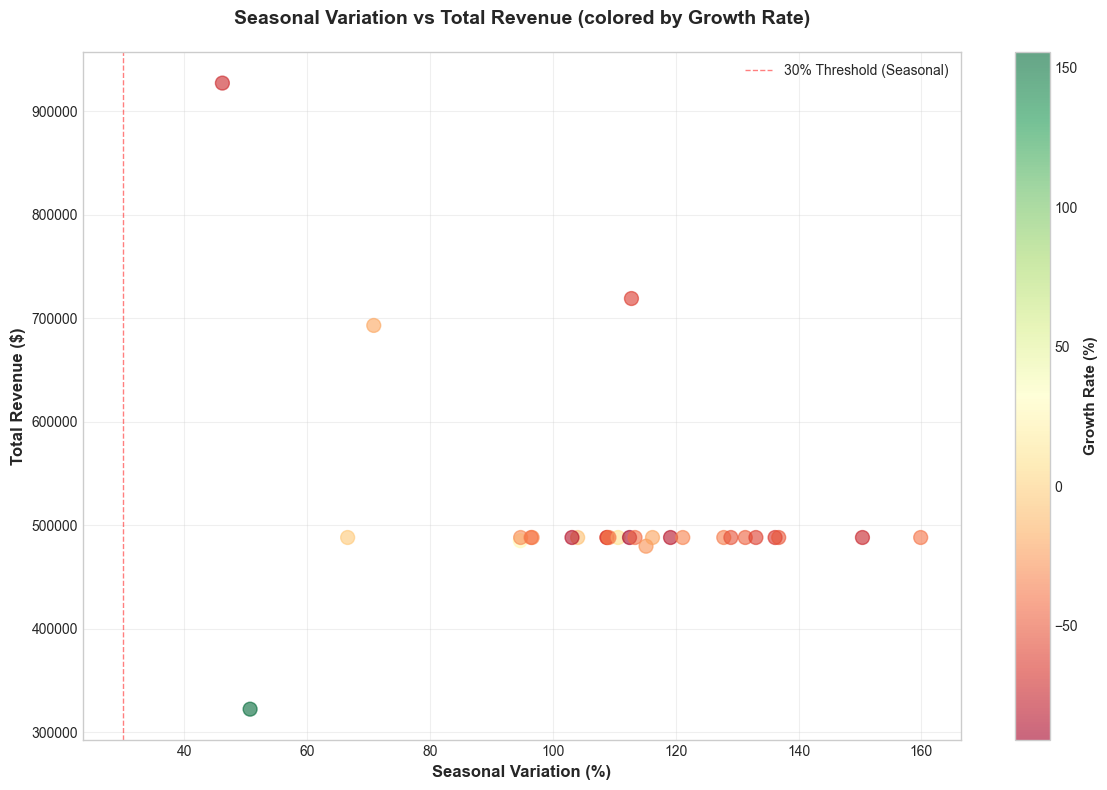

📊 Chart shows: Relationship between seasonal variation and revenue
   Insight: Products to the right of red line are highly seasonal
   Color indicates growth - green = growing, red = declining
   High revenue + low variation = stable cash cows


In [71]:
if len(seasonal_analysis_df) > 0:
    # Visualization 4: Seasonal Variation vs Total Revenue
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(seasonal_analysis_df['seasonal_variation'], 
                         seasonal_analysis_df['total_revenue'],
                         c=seasonal_analysis_df['growth_rate'], 
                         s=100, alpha=0.6, cmap='RdYlGn')
    ax.set_xlabel('Seasonal Variation (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    ax.set_title('Seasonal Variation vs Total Revenue (colored by Growth Rate)', fontsize=14, fontweight='bold', pad=20)
    ax.grid(alpha=0.3)
    
    # Add threshold line
    ax.axvline(30, color='red', linestyle='--', linewidth=1, alpha=0.5, label='30% Threshold (Seasonal)')
    ax.legend()
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Growth Rate (%)', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Chart shows: Relationship between seasonal variation and revenue")
    print("   Insight: Products to the right of red line are highly seasonal")
    print("   Color indicates growth - green = growing, red = declining")
    print("   High revenue + low variation = stable cash cows")
else:
    print("⚠ No data available for visualization")


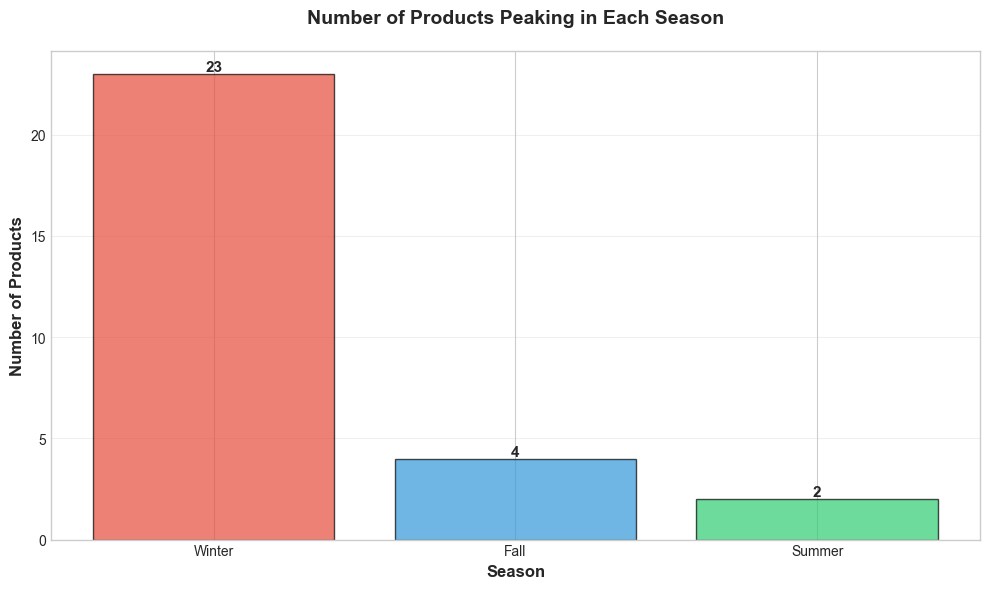

📊 Chart shows: Which season is peak season for most products
   Insight: Winter is the most common peak season (23 products)
   Plan inventory and marketing around peak seasons


In [72]:
if len(seasonal_analysis_df) > 0:
    # Visualization 5: Best Season Distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    seasonal_counts = seasonal_analysis_df['best_season'].value_counts()
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
    bars = ax.bar(seasonal_counts.index, seasonal_counts.values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Season', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
    ax.set_title('Number of Products Peaking in Each Season', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (season, count) in enumerate(seasonal_counts.items()):
        ax.text(i, count, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    best_season = seasonal_counts.idxmax()
    print(f"📊 Chart shows: Which season is peak season for most products")
    print(f"   Insight: {best_season} is the most common peak season ({seasonal_counts[best_season]} products)")
    print("   Plan inventory and marketing around peak seasons")
else:
    print("⚠ No data available for visualization")


## Step 8: Detailed Product Reports


In [73]:
if len(seasonal_analysis_df) > 0:
    # Create detailed monthly breakdown for each product
    product_monthly_reports = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        monthly_breakdown = product_trends.groupby('month').agg({
            'total_revenue': 'sum',
            'total_sales': 'sum'
        }).reset_index()
        
        for _, month_data in monthly_breakdown.iterrows():
            report = {
                'listing_id': listing_id,
                'title': product_info['title'],
                'month': int(month_data['month']),
                'month_name': pd.to_datetime(f"2024-{int(month_data['month'])}-01").strftime('%B'),
                'month_revenue': month_data['total_revenue'],
                'month_sales': month_data['total_sales'],
                'total_revenue': product_info['total_revenue'],
                'best_month': product_info['best_month'],
                'best_season': product_info['best_season'],
                'is_seasonal': product_info['is_seasonal'],
                'seasonal_variation': product_info['seasonal_variation'],
                'growth_rate': product_info['growth_rate'],
            }
            product_monthly_reports.append(report)
    
    monthly_reports_df = pd.DataFrame(product_monthly_reports)
    monthly_reports_df.to_csv('product_monthly_breakdown.csv', index=False, encoding='utf-8')
    
    print("✓ Exported: product_monthly_breakdown.csv")
    print(f"  - Contains monthly breakdown for {monthly_reports_df['listing_id'].nunique()} products")
    print(f"  - Total records: {len(monthly_reports_df)}")
    
    print("\n" + "="*70)
    print("DETAILED PRODUCT REPORTS")
    print("="*70)
    
    # Show sample reports for top 5 products
    top_5 = seasonal_analysis_df.nlargest(5, 'total_revenue')
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    print(f"\n📋 SAMPLE REPORTS - Top 5 Products:")
    for idx, product in top_5.iterrows():
        print(f"\n{idx+1}. {product['title'][:60]}")
        print(f"   Total Revenue: ${product['total_revenue']:,.2f}")
        print(f"   Best Month: {month_names[int(product['best_month'])-1]} (${product['best_month_revenue']:,.2f})")
        print(f"   Best Season: {product['best_season']} (${product['best_season_revenue']:,.2f})")
        print(f"   Type: {'Seasonal' if product['is_seasonal'] else 'Stable'} (Variation: {product['seasonal_variation']:.1f}%)")
        print(f"   Growth: {product['growth_rate']:.1f}%")
else:
    print("⚠ No data available for detailed reports")


✓ Exported: product_monthly_breakdown.csv
  - Contains monthly breakdown for 29 products
  - Total records: 348

DETAILED PRODUCT REPORTS

📋 SAMPLE REPORTS - Top 5 Products:

8. Guess Who Mommy or Daddy Game Baby Shower Party Game Mommy o
   Total Revenue: $927,207.60
   Best Month: Jul ($1,291.05)
   Best Season: Summer ($2,924.10)
   Type: Seasonal (Variation: 46.2%)
   Growth: -72.4%

17. Saveopoly Savings Challenge - PRINTABLE Journal Page - Print
   Total Revenue: $718,981.51
   Best Month: Dec ($6,101.81)
   Best Season: Winter ($8,952.71)
   Type: Seasonal (Variation: 112.8%)
   Growth: -62.4%

23. Swatch Test - PRINTABLE Journal Page - Planner Page - Color 
   Total Revenue: $692,965.68
   Best Month: Dec ($713.55)
   Best Season: Fall ($1,648.62)
   Type: Seasonal (Variation: 70.9%)
   Growth: -20.5%

1. 24 Hour Sleep Tracker - PRINTABLE Journal Page - Monthly Sle
   Total Revenue: $488,004.00
   Best Month: Dec ($643.50)
   Best Season: Fall ($1,246.50)
   Type: Seasonal (Var

## Step 9: Expert Recommendations Per Product


In [74]:
if len(seasonal_analysis_df) > 0:
    print("="*80)
    print("EXPERT RECOMMENDATIONS - PRODUCT-SPECIFIC SEASONAL STRATEGIES")
    print("="*80)
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Seasonal products recommendations
    seasonal_products = seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == True].nlargest(10, 'total_revenue')
    
    print(f"\n📈 SEASONAL PRODUCTS STRATEGY (Top 10 by Revenue):")
    print("-" * 80)
    for idx, product in seasonal_products.iterrows():
        print(f"\n{idx+1}. {product['title'][:60]}")
        print(f"   • Peak Month: {month_names[int(product['best_month'])-1]}")
        print(f"   • Peak Season: {product['best_season']}")
        print(f"   • Recommendation: Increase inventory 2-3 months before peak")
        print(f"   • Marketing: Launch campaigns 1 month before peak month")
        print(f"   • Revenue Potential: ${product['best_month_revenue']:,.2f} in best month")
    
    # Stable products recommendations
    stable_products = seasonal_analysis_df[seasonal_analysis_df['is_seasonal'] == False].nlargest(10, 'total_revenue')
    
    print(f"\n\n📊 STABLE PRODUCTS STRATEGY (Top 10 by Revenue):")
    print("-" * 80)
    for idx, product in stable_products.iterrows():
        print(f"\n{idx+1}. {product['title'][:60]}")
        print(f"   • Best Month: {month_names[int(product['best_month'])-1]}")
        print(f"   • Variation: {product['seasonal_variation']:.1f}% (low variation)")
        print(f"   • Recommendation: Maintain consistent inventory year-round")
        print(f"   • Marketing: Steady, consistent campaigns throughout the year")
        print(f"   • Revenue: ${product['total_revenue']:,.2f} total")
    
    # Growing products recommendations
    growing_products = seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 10].nlargest(10, 'growth_rate')
    
    if len(growing_products) > 0:
        print(f"\n\n🚀 GROWING PRODUCTS STRATEGY (Top 10 by Growth Rate):")
        print("-" * 80)
        for idx, product in growing_products.iterrows():
            print(f"\n{idx+1}. {product['title'][:60]}")
            print(f"   • Growth Rate: {product['growth_rate']:.1f}%")
            print(f"   • Recommendation: Increase investment and inventory")
            print(f"   • Marketing: Scale up campaigns to capitalize on growth trend")
            print(f"   • Revenue: ${product['total_revenue']:,.2f} (growing)")
    
    print(f"\n\n💡 KEY INSIGHTS:")
    print(f"  • {len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal']==True])} products require seasonal inventory planning")
    print(f"  • {len(seasonal_analysis_df[seasonal_analysis_df['is_seasonal']==False])} products can maintain steady inventory")
    print(f"  • {len(seasonal_analysis_df[seasonal_analysis_df['growth_rate']>0])} products are growing - prioritize these")
    print(f"  • Plan product launches around peak months for maximum impact")
else:
    print("⚠ No data available for recommendations")


EXPERT RECOMMENDATIONS - PRODUCT-SPECIFIC SEASONAL STRATEGIES

📈 SEASONAL PRODUCTS STRATEGY (Top 10 by Revenue):
--------------------------------------------------------------------------------

8. Guess Who Mommy or Daddy Game Baby Shower Party Game Mommy o
   • Peak Month: Jul
   • Peak Season: Summer
   • Recommendation: Increase inventory 2-3 months before peak
   • Marketing: Launch campaigns 1 month before peak month
   • Revenue Potential: $1,291.05 in best month

17. Saveopoly Savings Challenge - PRINTABLE Journal Page - Print
   • Peak Month: Dec
   • Peak Season: Winter
   • Recommendation: Increase inventory 2-3 months before peak
   • Marketing: Launch campaigns 1 month before peak month
   • Revenue Potential: $6,101.81 in best month

23. Swatch Test - PRINTABLE Journal Page - Planner Page - Color 
   • Peak Month: Dec
   • Peak Season: Fall
   • Recommendation: Increase inventory 2-3 months before peak
   • Marketing: Launch campaigns 1 month before peak month
   • Revenu

## Step 10: Advanced Seasonal Insights & Additional Analyses

This section provides deeper insights beyond basic seasonal patterns:
- **Revenue Concentration**: How much revenue comes from peak periods?
- **Holiday Impact**: Analysis of holiday months (Dec, Nov, etc.)
- **Cross-Product Seasonality**: Products that peak together
- **Portfolio Diversification**: Balance across seasons
- **Revenue Volatility**: Risk assessment by product
- **Optimal Launch Timing**: Best months to launch new products
- **Seasonal Momentum**: Products with strengthening/weakening seasonality
- **Peak Duration**: How long peak seasons last


In [75]:
# Advanced Analysis 1: Revenue Concentration Analysis
# How much of each product's revenue comes from peak months/seasons?

if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 1: REVENUE CONCENTRATION")
    print("="*80)
    
    revenue_concentration = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        total_revenue = product_trends['total_revenue'].sum()
        if total_revenue == 0:
            continue
        
        # Best month concentration
        best_month_revenue = product_trends[product_trends['month'] == product_info['best_month']]['total_revenue'].sum()
        best_month_pct = (best_month_revenue / total_revenue) * 100
        
        # Top 3 months concentration
        monthly_revenue = product_trends.groupby('month')['total_revenue'].sum().sort_values(ascending=False)
        top3_months_revenue = monthly_revenue.head(3).sum()
        top3_months_pct = (top3_months_revenue / total_revenue) * 100
        
        # Best season concentration
        best_season_revenue = product_trends[product_trends['season'] == product_info['best_season']]['total_revenue'].sum()
        best_season_pct = (best_season_revenue / total_revenue) * 100
        
        # Peak quarter (3 months around best month)
        best_month_num = int(product_info['best_month'])
        peak_months = [(best_month_num - 1) % 12 + 1, best_month_num, (best_month_num + 1) % 12 + 1]
        peak_quarter_revenue = product_trends[product_trends['month'].isin(peak_months)]['total_revenue'].sum()
        peak_quarter_pct = (peak_quarter_revenue / total_revenue) * 100
        
        revenue_concentration.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': total_revenue,
            'best_month_pct': best_month_pct,
            'top3_months_pct': top3_months_pct,
            'best_season_pct': best_season_pct,
            'peak_quarter_pct': peak_quarter_pct,
            'concentration_risk': 'High' if top3_months_pct > 60 else 'Medium' if top3_months_pct > 40 else 'Low'
        })
    
    concentration_df = pd.DataFrame(revenue_concentration)
    
    print(f"\n📊 Revenue Concentration Summary:")
    print(f"  • Average best month concentration: {concentration_df['best_month_pct'].mean():.1f}%")
    print(f"  • Average top 3 months concentration: {concentration_df['top3_months_pct'].mean():.1f}%")
    print(f"  • Average best season concentration: {concentration_df['best_season_pct'].mean():.1f}%")
    print(f"  • Average peak quarter (3 months) concentration: {concentration_df['peak_quarter_pct'].mean():.1f}%")
    
    print(f"\n⚠️  Concentration Risk:")
    high_risk = len(concentration_df[concentration_df['concentration_risk'] == 'High'])
    medium_risk = len(concentration_df[concentration_df['concentration_risk'] == 'Medium'])
    low_risk = len(concentration_df[concentration_df['concentration_risk'] == 'Low'])
    print(f"  • High risk (>60% in top 3 months): {high_risk} products")
    print(f"  • Medium risk (40-60%): {medium_risk} products")
    print(f"  • Low risk (<40%): {low_risk} products")
    
    print(f"\n💡 Insight: Products with high concentration are more vulnerable to seasonal fluctuations")
    print(f"   Consider diversifying marketing efforts across more months for high-risk products")
    
    # Show top 5 most concentrated products
    print(f"\n🔝 Top 5 Most Concentrated Products (by top 3 months %):")
    top_concentrated = concentration_df.nlargest(5, 'top3_months_pct')
    for idx, row in top_concentrated.iterrows():
        print(f"  {idx+1}. {row['title'][:55]}")
        print(f"     Top 3 months: {row['top3_months_pct']:.1f}% | Best month: {row['best_month_pct']:.1f}% | Risk: {row['concentration_risk']}")
    
else:
    concentration_df = pd.DataFrame()
    print("⚠ No data available for revenue concentration analysis")


ADVANCED ANALYSIS 1: REVENUE CONCENTRATION

📊 Revenue Concentration Summary:
  • Average best month concentration: 30.8%
  • Average top 3 months concentration: 62.8%
  • Average best season concentration: 48.8%
  • Average peak quarter (3 months) concentration: 36.7%

⚠️  Concentration Risk:
  • High risk (>60% in top 3 months): 20 products
  • Medium risk (40-60%): 9 products
  • Low risk (<40%): 0 products

💡 Insight: Products with high concentration are more vulnerable to seasonal fluctuations
   Consider diversifying marketing efforts across more months for high-risk products

🔝 Top 5 Most Concentrated Products (by top 3 months %):
  29. Reading Log Chart - PRINTABLE Journal Page - Planner Pa
     Top 3 months: 79.8% | Best month: 44.3% | Risk: High
  20. Sleep Tracker Yearly - PRINTABLE Journal Page - Planner
     Top 3 months: 75.5% | Best month: 36.9% | Risk: High
  13. Shower Tracker - PRINTABLE Journal Page - Planner Page 
     Top 3 months: 75.4% | Best month: 35.1% | Risk: 

In [76]:
# Advanced Analysis 2: Holiday Impact Analysis
# Analyze performance during holiday months (Dec, Nov, Jan, Feb)

if len(trends_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 2: HOLIDAY IMPACT ANALYSIS")
    print("="*80)
    
    # Define holiday months
    holiday_months = {
        'December': 12,  # Christmas, New Year
        'November': 11,  # Black Friday, Thanksgiving
        'January': 1,    # New Year resolutions
        'February': 2,   # Valentine's Day
        'May': 5,        # Mother's Day
        'June': 6        # Father's Day, graduations
    }
    
    holiday_analysis = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        total_revenue = product_trends['total_revenue'].sum()
        if total_revenue == 0:
            continue
        
        # Calculate holiday month performance
        holiday_revenue = product_trends[product_trends['month'].isin(holiday_months.values())]['total_revenue'].sum()
        holiday_pct = (holiday_revenue / total_revenue) * 100
        
        # Specific holiday months
        dec_revenue = product_trends[product_trends['month'] == 12]['total_revenue'].sum()
        nov_revenue = product_trends[product_trends['month'] == 11]['total_revenue'].sum()
        dec_pct = (dec_revenue / total_revenue) * 100 if total_revenue > 0 else 0
        nov_pct = (nov_revenue / total_revenue) * 100 if total_revenue > 0 else 0
        
        # Compare to average month
        avg_monthly_revenue = total_revenue / product_trends['month'].nunique()
        dec_vs_avg = (dec_revenue / avg_monthly_revenue) * 100 if avg_monthly_revenue > 0 else 0
        nov_vs_avg = (nov_revenue / avg_monthly_revenue) * 100 if avg_monthly_revenue > 0 else 0
        
        holiday_analysis.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': total_revenue,
            'holiday_months_pct': holiday_pct,
            'december_pct': dec_pct,
            'november_pct': nov_pct,
            'december_vs_avg': dec_vs_avg,
            'november_vs_avg': nov_vs_avg,
            'is_holiday_driven': dec_pct > 15 or nov_pct > 15
        })
    
    holiday_df = pd.DataFrame(holiday_analysis)
    
    print(f"\n📊 Holiday Month Performance:")
    print(f"  • Average revenue from holiday months: {holiday_df['holiday_months_pct'].mean():.1f}%")
    print(f"  • Average December revenue: {holiday_df['december_pct'].mean():.1f}%")
    print(f"  • Average November revenue: {holiday_df['november_pct'].mean():.1f}%")
    print(f"  • December vs average month: {holiday_df['december_vs_avg'].mean():.1f}%")
    print(f"  • November vs average month: {holiday_df['november_vs_avg'].mean():.1f}%")
    
    holiday_driven = len(holiday_df[holiday_df['is_holiday_driven'] == True])
    print(f"\n🎄 Holiday-Driven Products (>15% in Dec or Nov): {holiday_driven} products")
    
    print(f"\n🔝 Top 5 Holiday-Driven Products:")
    top_holiday = holiday_df.nlargest(5, 'holiday_months_pct')
    for idx, row in top_holiday.iterrows():
        print(f"  {idx+1}. {row['title'][:55]}")
        print(f"     Dec: {row['december_pct']:.1f}% | Nov: {row['november_pct']:.1f}% | Holiday months: {row['holiday_months_pct']:.1f}%")
    
    print(f"\n💡 Insight: Holiday-driven products need aggressive Q4 marketing and inventory planning")
    
else:
    holiday_df = pd.DataFrame()
    print("⚠ No data available for holiday analysis")


ADVANCED ANALYSIS 2: HOLIDAY IMPACT ANALYSIS

📊 Holiday Month Performance:
  • Average revenue from holiday months: 68.8%
  • Average December revenue: 29.0%
  • Average November revenue: 19.4%
  • December vs average month: 347.9%
  • November vs average month: 233.3%

🎄 Holiday-Driven Products (>15% in Dec or Nov): 27 products

🔝 Top 5 Holiday-Driven Products:
  29. Reading Log Chart - PRINTABLE Journal Page - Planner Pa
     Dec: 44.3% | Nov: 25.5% | Holiday months: 83.1%
  13. Shower Tracker - PRINTABLE Journal Page - Planner Page 
     Dec: 35.1% | Nov: 27.9% | Holiday months: 82.8%
  20. Sleep Tracker Yearly - PRINTABLE Journal Page - Planner
     Dec: 36.9% | Nov: 25.0% | Holiday months: 82.8%
  25. Water Tracker Yearly - PRINTABLE Journal Page - Planner
     Dec: 38.6% | Nov: 21.4% | Holiday months: 81.5%
  21. Step Tracker Yearly - PRINTABLE Journal Page - Planner 
     Dec: 35.3% | Nov: 26.7% | Holiday months: 79.4%

💡 Insight: Holiday-driven products need aggressive Q4 marke

In [77]:
# Advanced Analysis 3: Cross-Product Seasonality & Portfolio Diversification
# Identify products that peak together and assess portfolio balance

if len(seasonal_analysis_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 3: PORTFOLIO DIVERSIFICATION & CROSS-PRODUCT SEASONALITY")
    print("="*80)
    
    # Season distribution
    season_distribution = seasonal_analysis_df['best_season'].value_counts()
    total_products = len(seasonal_analysis_df)
    
    print(f"\n📊 Portfolio Distribution by Peak Season:")
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        count = season_distribution.get(season, 0)
        pct = (count / total_products) * 100 if total_products > 0 else 0
        print(f"  • {season}: {count} products ({pct:.1f}%)")
    
    # Calculate diversification score (0-100, higher = more balanced)
    ideal_distribution = total_products / 4  # 25% per season
    diversification_score = 100 - sum(abs(season_distribution.get(s, 0) - ideal_distribution) for s in ['Spring', 'Summer', 'Fall', 'Winter']) / total_products * 100
    
    print(f"\n📈 Portfolio Diversification Score: {diversification_score:.1f}/100")
    if diversification_score > 75:
        print("   ✓ Well-diversified portfolio across seasons")
    elif diversification_score > 50:
        print("   ⚠ Moderately diversified - consider adding products to underrepresented seasons")
    else:
        print("   ⚠ Low diversification - portfolio heavily concentrated in certain seasons")
    
    # Products peaking in same season
    print(f"\n🔗 Products Peaking Together (by Season):")
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        season_products = seasonal_analysis_df[seasonal_analysis_df['best_season'] == season]
        if len(season_products) > 1:
            print(f"\n  {season} ({len(season_products)} products):")
            top_3 = season_products.nlargest(3, 'total_revenue')
            for idx, row in top_3.iterrows():
                print(f"    • {row['title'][:50]} (${row['total_revenue']:,.0f})")
            print(f"    💡 Insight: {len(season_products)} products compete for {season} market")
    
    # Month distribution
    month_distribution = seasonal_analysis_df['best_month'].value_counts().sort_index()
    print(f"\n📅 Portfolio Distribution by Peak Month:")
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    peak_months = month_distribution.nlargest(3)
    for month_num, count in peak_months.items():
        print(f"  • {month_names[int(month_num)-1]}: {count} products")
    
    print(f"\n💡 Strategic Insight:")
    print(f"   • Products peaking in same season may compete for marketing budget")
    print(f"   • Consider launching new products in underrepresented seasons")
    print(f"   • Balance inventory planning across all seasons")
    
else:
    print("⚠ No data available for portfolio analysis")


ADVANCED ANALYSIS 3: PORTFOLIO DIVERSIFICATION & CROSS-PRODUCT SEASONALITY

📊 Portfolio Distribution by Peak Season:
  • Spring: 0 products (0.0%)
  • Summer: 2 products (6.9%)
  • Fall: 4 products (13.8%)
  • Winter: 23 products (79.3%)

📈 Portfolio Diversification Score: -8.6/100
   ⚠ Low diversification - portfolio heavily concentrated in certain seasons

🔗 Products Peaking Together (by Season):

  Summer (2 products):
    • Guess Who Mommy or Daddy Game Baby Shower Party Ga ($927,208)
    • Printable Birthday Card Floral Birthday Card Flowe ($322,083)
    💡 Insight: 2 products compete for Summer market

  Fall (4 products):
    • Swatch Test - PRINTABLE Journal Page - Planner Pag ($692,966)
    • 24 Hour Sleep Tracker - PRINTABLE Journal Page - M ($488,004)
    • Weather Tracker - PRINTABLE Journal Page - Planner ($488,004)
    💡 Insight: 4 products compete for Fall market

  Winter (23 products):
    • Saveopoly Savings Challenge - PRINTABLE Journal Pa ($718,982)
    • Adulting Tr

In [78]:
# Advanced Analysis 4: Revenue Volatility & Risk Assessment
# Assess which products have the most volatile seasonal patterns

if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 4: REVENUE VOLATILITY & RISK ASSESSMENT")
    print("="*80)
    
    volatility_analysis = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        monthly_revenue = product_trends.groupby('month')['total_revenue'].sum()
        
        if len(monthly_revenue) < 2:
            continue
        
        # Calculate volatility metrics
        mean_revenue = monthly_revenue.mean()
        std_revenue = monthly_revenue.std()
        cv = (std_revenue / mean_revenue) * 100 if mean_revenue > 0 else 0  # Coefficient of variation
        
        # Min/Max ratio
        min_revenue = monthly_revenue.min()
        max_revenue = monthly_revenue.max()
        min_max_ratio = (min_revenue / max_revenue) * 100 if max_revenue > 0 else 0
        
        # Risk classification
        if cv > 100:
            risk_level = 'Very High'
        elif cv > 70:
            risk_level = 'High'
        elif cv > 40:
            risk_level = 'Medium'
        else:
            risk_level = 'Low'
        
        volatility_analysis.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': product_info['total_revenue'],
            'volatility_cv': cv,
            'min_max_ratio': min_max_ratio,
            'risk_level': risk_level,
            'std_revenue': std_revenue,
            'mean_revenue': mean_revenue
        })
    
    volatility_df = pd.DataFrame(volatility_analysis)
    
    print(f"\n📊 Volatility Summary:")
    print(f"  • Average coefficient of variation: {volatility_df['volatility_cv'].mean():.1f}%")
    print(f"  • Average min/max ratio: {volatility_df['min_max_ratio'].mean():.1f}%")
    
    print(f"\n⚠️  Risk Distribution:")
    for risk in ['Very High', 'High', 'Medium', 'Low']:
        count = len(volatility_df[volatility_df['risk_level'] == risk])
        pct = (count / len(volatility_df)) * 100 if len(volatility_df) > 0 else 0
        print(f"  • {risk} risk: {count} products ({pct:.1f}%)")
    
    print(f"\n🔝 Top 5 Most Volatile Products (Highest Risk):")
    top_volatile = volatility_df.nlargest(5, 'volatility_cv')
    for idx, row in top_volatile.iterrows():
        print(f"  {idx+1}. {row['title'][:55]}")
        print(f"     Volatility: {row['volatility_cv']:.1f}% | Risk: {row['risk_level']} | Min/Max: {row['min_max_ratio']:.1f}%")
    
    print(f"\n💡 Insight: High volatility products require more careful inventory management")
    print(f"   Consider maintaining safety stock for high-risk products")
    
    # Export volatility analysis
    if len(volatility_df) > 0:
        volatility_df.to_csv('product_volatility_analysis.csv', index=False, encoding='utf-8')
        print(f"\n✓ Exported: product_volatility_analysis.csv")
    
else:
    volatility_df = pd.DataFrame()
    print("⚠ No data available for volatility analysis")


ADVANCED ANALYSIS 4: REVENUE VOLATILITY & RISK ASSESSMENT

📊 Volatility Summary:
  • Average coefficient of variation: 109.5%
  • Average min/max ratio: 4.3%

⚠️  Risk Distribution:
  • Very High risk: 21 products (72.4%)
  • High risk: 5 products (17.2%)
  • Medium risk: 3 products (10.3%)
  • Low risk: 0 products (0.0%)

🔝 Top 5 Most Volatile Products (Highest Risk):
  29. Reading Log Chart - PRINTABLE Journal Page - Planner Pa
     Volatility: 159.9% | Risk: Very High | Min/Max: 0.0%
  22. Stress Tracker - PRINTABLE Journal Page - Habit Tracker
     Volatility: 150.4% | Risk: Very High | Min/Max: 0.2%
  20. Sleep Tracker Yearly - PRINTABLE Journal Page - Planner
     Volatility: 136.8% | Risk: Very High | Min/Max: 1.3%
  13. Shower Tracker - PRINTABLE Journal Page - Planner Page 
     Volatility: 136.2% | Risk: Very High | Min/Max: 3.2%
  25. Water Tracker Yearly - PRINTABLE Journal Page - Planner
     Volatility: 133.1% | Risk: Very High | Min/Max: 1.7%

💡 Insight: High volatility 

In [79]:
# Advanced Analysis 5: Optimal Launch Timing Analysis
# Determine best months to launch new products based on existing patterns

if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 5: OPTIMAL LAUNCH TIMING ANALYSIS")
    print("="*80)
    
    # Aggregate monthly performance across all products
    monthly_performance = trends_df.groupby('month').agg({
        'total_revenue': 'sum',
        'total_sales': 'sum',
        'listing_id': 'nunique'
    }).reset_index()
    
    monthly_performance['avg_revenue_per_product'] = monthly_performance['total_revenue'] / monthly_performance['listing_id']
    monthly_performance['month_name'] = monthly_performance['month'].apply(lambda x: ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][int(x)-1])
    
    # Rank months
    monthly_performance = monthly_performance.sort_values('avg_revenue_per_product', ascending=False)
    
    print(f"\n📊 Best Months to Launch New Products (by average revenue per product):")
    print(f"\n  Top 5 Launch Months:")
    for idx, row in monthly_performance.head(5).iterrows():
        print(f"    {row['month_name']}: ${row['avg_revenue_per_product']:,.2f} avg revenue/product | {int(row['listing_id'])} products active")
    
    print(f"\n  Worst 3 Launch Months (avoid if possible):")
    for idx, row in monthly_performance.tail(3).iterrows():
        print(f"    {row['month_name']}: ${row['avg_revenue_per_product']:,.2f} avg revenue/product | {int(row['listing_id'])} products active")
    
    # Calculate launch timing recommendations
    best_launch_month = monthly_performance.iloc[0]['month']
    best_launch_name = monthly_performance.iloc[0]['month_name']
    
    # Pre-launch months (2-3 months before peak)
    pre_launch_months = []
    for i in [2, 3]:
        pre_month = ((best_launch_month - i - 1) % 12) + 1
        pre_launch_months.append(pre_month)
    
    print(f"\n💡 Launch Strategy Recommendations:")
    print(f"  • Best launch month: {best_launch_name} (highest average revenue per product)")
    print(f"  • Pre-launch preparation: Start marketing 2-3 months before {best_launch_name}")
    print(f"  • Consider launching in months with lower competition but good revenue potential")
    
    # Competition analysis
    print(f"\n📈 Competition Level by Month:")
    monthly_performance_sorted = monthly_performance.sort_values('listing_id', ascending=False)
    print(f"  Most competitive months (most products active):")
    for idx, row in monthly_performance_sorted.head(3).iterrows():
        print(f"    {row['month_name']}: {int(row['listing_id'])} products")
    
    print(f"  Least competitive months (opportunity for new launches):")
    for idx, row in monthly_performance_sorted.tail(3).iterrows():
        print(f"    {row['month_name']}: {int(row['listing_id'])} products | Avg revenue: ${row['avg_revenue_per_product']:,.2f}")
    
    # Export launch timing analysis
    monthly_performance.to_csv('optimal_launch_timing.csv', index=False, encoding='utf-8')
    print(f"\n✓ Exported: optimal_launch_timing.csv")
    
else:
    print("⚠ No data available for launch timing analysis")


ADVANCED ANALYSIS 5: OPTIMAL LAUNCH TIMING ANALYSIS

📊 Best Months to Launch New Products (by average revenue per product):

  Top 5 Launch Months:
    Dec: $1,339.99 avg revenue/product | 29 products active
    Nov: $911.19 avg revenue/product | 29 products active
    Jan: $497.34 avg revenue/product | 29 products active
    Sep: $387.84 avg revenue/product | 29 products active
    Oct: $331.36 avg revenue/product | 29 products active

  Worst 3 Launch Months (avoid if possible):
    Apr: $119.35 avg revenue/product | 29 products active
    Jun: $107.67 avg revenue/product | 29 products active
    May: $68.34 avg revenue/product | 29 products active

💡 Launch Strategy Recommendations:
  • Best launch month: Dec (highest average revenue per product)
  • Pre-launch preparation: Start marketing 2-3 months before Dec
  • Consider launching in months with lower competition but good revenue potential

📈 Competition Level by Month:
  Most competitive months (most products active):
    Dec: 2

In [80]:
# Advanced Analysis 6: Seasonal Momentum Analysis
# Identify products with strengthening or weakening seasonal patterns

if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 6: SEASONAL MOMENTUM ANALYSIS")
    print("="*80)
    
    momentum_analysis = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        # Split data into first half and second half of time period
        product_trends = product_trends.sort_values('date')
        mid_point = len(product_trends) // 2
        
        if mid_point < 2:
            continue
        
        first_half = product_trends.iloc[:mid_point]
        second_half = product_trends.iloc[mid_point:]
        
        # Calculate seasonal variation for each half
        first_half_monthly = first_half.groupby('month')['total_revenue'].sum()
        second_half_monthly = second_half.groupby('month')['total_revenue'].sum()
        
        if len(first_half_monthly) < 2 or len(second_half_monthly) < 2:
            continue
        
        first_half_cv = (first_half_monthly.std() / first_half_monthly.mean()) * 100 if first_half_monthly.mean() > 0 else 0
        second_half_cv = (second_half_monthly.std() / second_half_monthly.mean()) * 100 if second_half_monthly.mean() > 0 else 0
        
        # Momentum: change in seasonality strength
        momentum = second_half_cv - first_half_cv
        
        # Determine momentum direction
        if momentum > 10:
            momentum_direction = 'Strengthening'
        elif momentum < -10:
            momentum_direction = 'Weakening'
        else:
            momentum_direction = 'Stable'
        
        # Revenue trend
        first_half_revenue = first_half['total_revenue'].sum()
        second_half_revenue = second_half['total_revenue'].sum()
        revenue_change = ((second_half_revenue - first_half_revenue) / first_half_revenue) * 100 if first_half_revenue > 0 else 0
        
        momentum_analysis.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': product_info['total_revenue'],
            'first_half_cv': first_half_cv,
            'second_half_cv': second_half_cv,
            'seasonal_momentum': momentum,
            'momentum_direction': momentum_direction,
            'revenue_change': revenue_change
        })
    
    momentum_df = pd.DataFrame(momentum_analysis)
    
    print(f"\n📊 Seasonal Momentum Summary:")
    strengthening = len(momentum_df[momentum_df['momentum_direction'] == 'Strengthening'])
    weakening = len(momentum_df[momentum_df['momentum_direction'] == 'Weakening'])
    stable = len(momentum_df[momentum_df['momentum_direction'] == 'Stable'])
    
    print(f"  • Strengthening seasonality: {strengthening} products")
    print(f"  • Weakening seasonality: {weakening} products")
    print(f"  • Stable seasonality: {stable} products")
    
    print(f"\n📈 Products with Strengthening Seasonality (increasing variation):")
    strengthening_products = momentum_df[momentum_df['momentum_direction'] == 'Strengthening'].nlargest(5, 'seasonal_momentum')
    if len(strengthening_products) > 0:
        for idx, row in strengthening_products.iterrows():
            print(f"  • {row['title'][:55]}")
            print(f"    Momentum: +{row['seasonal_momentum']:.1f}% | Revenue change: {row['revenue_change']:+.1f}%")
    else:
        print("  None found")
    
    print(f"\n📉 Products with Weakening Seasonality (becoming more stable):")
    weakening_products = momentum_df[momentum_df['momentum_direction'] == 'Weakening'].nsmallest(5, 'seasonal_momentum')
    if len(weakening_products) > 0:
        for idx, row in weakening_products.iterrows():
            print(f"  • {row['title'][:55]}")
            print(f"    Momentum: {row['seasonal_momentum']:.1f}% | Revenue change: {row['revenue_change']:+.1f}%")
    else:
        print("  None found")
    
    print(f"\n💡 Insight: Products with strengthening seasonality need more aggressive seasonal planning")
    print(f"   Products with weakening seasonality may be transitioning to year-round products")
    
    # Export momentum analysis
    if len(momentum_df) > 0:
        momentum_df.to_csv('product_seasonal_momentum.csv', index=False, encoding='utf-8')
        print(f"\n✓ Exported: product_seasonal_momentum.csv")
    
else:
    momentum_df = pd.DataFrame()
    print("⚠ No data available for momentum analysis")


ADVANCED ANALYSIS 6: SEASONAL MOMENTUM ANALYSIS

📊 Seasonal Momentum Summary:
  • Strengthening seasonality: 4 products
  • Weakening seasonality: 23 products
  • Stable seasonality: 2 products

📈 Products with Strengthening Seasonality (increasing variation):
  • Guess Who Mommy or Daddy Game Baby Shower Party Game Mo
    Momentum: +50.4% | Revenue change: -72.4%
  • Swatch Test - PRINTABLE Journal Page - Planner Page - C
    Momentum: +30.0% | Revenue change: -20.5%
  • Marker Tracker - PRINTABLE Journal Page - Planner Page 
    Momentum: +26.0% | Revenue change: +28.2%
  • 24 Hour Sleep Tracker - PRINTABLE Journal Page - Monthl
    Momentum: +14.2% | Revenue change: -3.5%

📉 Products with Weakening Seasonality (becoming more stable):
  • Reading Tracker - PRINTABLE Journal Page - Planner Page
    Momentum: -94.6% | Revenue change: -30.9%
  • Water Tracker Yearly - PRINTABLE Journal Page - Planner
    Momentum: -89.1% | Revenue change: -60.8%
  • Sleep Tracker Yearly - PRINTABLE Jour

In [81]:
# Advanced Analysis 7: Peak Duration & Recovery Analysis
# How long do peak seasons last and how quickly do products recover?

if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 7: PEAK DURATION & RECOVERY ANALYSIS")
    print("="*80)
    
    peak_duration_analysis = []
    
    for listing_id in trends_df['listing_id'].unique():
        product_trends = trends_df[trends_df['listing_id'] == listing_id].copy()
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        monthly_revenue = product_trends.groupby('month')['total_revenue'].sum()
        if len(monthly_revenue) < 3:
            continue
        
        mean_revenue = monthly_revenue.mean()
        best_month_revenue = monthly_revenue.max()
        threshold = mean_revenue * 1.2  # 20% above average = peak
        
        # Find peak months (above threshold)
        peak_months = monthly_revenue[monthly_revenue >= threshold].index.tolist()
        peak_duration = len(peak_months)
        
        # Calculate average revenue during peak vs off-peak
        peak_revenue_avg = monthly_revenue[monthly_revenue >= threshold].mean() if len(peak_months) > 0 else 0
        off_peak_revenue_avg = monthly_revenue[monthly_revenue < threshold].mean() if len(monthly_revenue[monthly_revenue < threshold]) > 0 else 0
        
        peak_multiplier = (peak_revenue_avg / off_peak_revenue_avg) if off_peak_revenue_avg > 0 else 0
        
        # Recovery analysis: months to return to baseline after peak
        best_month = int(product_info['best_month'])
        sorted_months = sorted(monthly_revenue.index)
        best_month_idx = sorted_months.index(best_month) if best_month in sorted_months else -1
        
        recovery_months = 0
        if best_month_idx >= 0 and best_month_idx < len(sorted_months) - 1:
            # Check how many months after peak until revenue drops below threshold
            for i in range(best_month_idx + 1, len(sorted_months)):
                month_rev = monthly_revenue[sorted_months[i]]
                if month_rev < threshold:
                    recovery_months = i - best_month_idx
                    break
        
        peak_duration_analysis.append({
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': product_info['total_revenue'],
            'peak_duration_months': peak_duration,
            'peak_multiplier': peak_multiplier,
            'recovery_months': recovery_months,
            'peak_category': 'Long' if peak_duration >= 4 else 'Medium' if peak_duration >= 2 else 'Short'
        })
    
    duration_df = pd.DataFrame(peak_duration_analysis)
    
    print(f"\n📊 Peak Duration Summary:")
    print(f"  • Average peak duration: {duration_df['peak_duration_months'].mean():.1f} months")
    print(f"  • Average peak multiplier: {duration_df['peak_multiplier'].mean():.1f}x (vs off-peak)")
    print(f"  • Average recovery time: {duration_df['recovery_months'].mean():.1f} months")
    
    print(f"\n⏱️  Peak Duration Distribution:")
    long_peak = len(duration_df[duration_df['peak_category'] == 'Long'])
    medium_peak = len(duration_df[duration_df['peak_category'] == 'Medium'])
    short_peak = len(duration_df[duration_df['peak_category'] == 'Short'])
    print(f"  • Long peak (4+ months): {long_peak} products")
    print(f"  • Medium peak (2-3 months): {medium_peak} products")
    print(f"  • Short peak (1 month): {short_peak} products")
    
    print(f"\n🔝 Products with Longest Peak Duration:")
    top_duration = duration_df.nlargest(5, 'peak_duration_months')
    for idx, row in top_duration.iterrows():
        print(f"  • {row['title'][:55]}")
        print(f"    Peak: {int(row['peak_duration_months'])} months | Multiplier: {row['peak_multiplier']:.1f}x | Recovery: {int(row['recovery_months'])} months")
    
    print(f"\n💡 Insight: Longer peak durations allow for better inventory planning")
    print(f"   Short peaks require precise timing for marketing and inventory")
    
    # Export duration analysis
    if len(duration_df) > 0:
        duration_df.to_csv('product_peak_duration.csv', index=False, encoding='utf-8')
        print(f"\n✓ Exported: product_peak_duration.csv")
    
else:
    duration_df = pd.DataFrame()
    print("⚠ No data available for peak duration analysis")


ADVANCED ANALYSIS 7: PEAK DURATION & RECOVERY ANALYSIS

📊 Peak Duration Summary:
  • Average peak duration: 3.0 months
  • Average peak multiplier: 6.3x (vs off-peak)
  • Average recovery time: 0.2 months

⏱️  Peak Duration Distribution:
  • Long peak (4+ months): 8 products
  • Medium peak (2-3 months): 21 products
  • Short peak (1 month): 0 products

🔝 Products with Longest Peak Duration:
  • Swatch Test - PRINTABLE Journal Page - Planner Page - C
    Peak: 6 months | Multiplier: 4.3x | Recovery: 0 months
  • Printable Birthday Card Floral Birthday Card Flower Bir
    Peak: 5 months | Multiplier: 2.4x | Recovery: 3 months
  • Wheel of Habits - Habit Tracker - PRINTABLE Journal Pag
    Peak: 5 months | Multiplier: 9.5x | Recovery: 0 months
  • 24 Hour Sleep Tracker - PRINTABLE Journal Page - Monthl
    Peak: 4 months | Multiplier: 3.1x | Recovery: 0 months
  • Dream Tracker - PRINTABLE Journal Page - Printable Plan
    Peak: 4 months | Multiplier: 9.8x | Recovery: 0 months

💡 Insight

In [82]:
# Advanced Analysis 8: Comprehensive Summary & Strategic Recommendations

if len(seasonal_analysis_df) > 0:
    print("="*80)
    print("ADVANCED ANALYSIS 8: COMPREHENSIVE STRATEGIC SUMMARY")
    print("="*80)
    
    # Combine all analyses
    summary_data = []
    
    for listing_id in seasonal_analysis_df['listing_id'].unique():
        product_info = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id].iloc[0]
        
        # Get additional metrics if available
        conc_info = concentration_df[concentration_df['listing_id'] == listing_id].iloc[0] if len(concentration_df) > 0 and listing_id in concentration_df['listing_id'].values else None
        holiday_info = holiday_df[holiday_df['listing_id'] == listing_id].iloc[0] if len(holiday_df) > 0 and listing_id in holiday_df['listing_id'].values else None
        vol_info = volatility_df[volatility_df['listing_id'] == listing_id].iloc[0] if len(volatility_df) > 0 and listing_id in volatility_df['listing_id'].values else None
        
        summary = {
            'listing_id': listing_id,
            'title': product_info['title'],
            'total_revenue': product_info['total_revenue'],
            'best_season': product_info['best_season'],
            'best_month': product_info['best_month'],
            'seasonal_variation': product_info['seasonal_variation'],
            'is_seasonal': product_info['is_seasonal'],
            'growth_rate': product_info['growth_rate'],
            'revenue_concentration': conc_info['top3_months_pct'] if conc_info is not None else None,
            'concentration_risk': conc_info['concentration_risk'] if conc_info is not None else None,
            'is_holiday_driven': holiday_info['is_holiday_driven'] if holiday_info is not None else None,
            'volatility_risk': vol_info['risk_level'] if vol_info is not None else None,
        }
        summary_data.append(summary)
    
    summary_df = pd.DataFrame(summary_data)
    
    print(f"\n📊 PORTFOLIO OVERVIEW:")
    print(f"  • Total products analyzed: {len(summary_df)}")
    print(f"  • Total revenue: ${summary_df['total_revenue'].sum():,.2f}")
    print(f"  • Average revenue per product: ${summary_df['total_revenue'].mean():,.2f}")
    
    print(f"\n🎯 KEY INSIGHTS:")
    
    # High-value seasonal products
    high_value_seasonal = summary_df[(summary_df['is_seasonal'] == True) & (summary_df['total_revenue'] > summary_df['total_revenue'].median())]
    print(f"\n  1. High-Value Seasonal Products: {len(high_value_seasonal)} products")
    print(f"     • These are your cash cows - prioritize inventory and marketing")
    print(f"     • Total revenue: ${high_value_seasonal['total_revenue'].sum():,.2f}")
    
    # Holiday-driven products
    if 'is_holiday_driven' in summary_df.columns and summary_df['is_holiday_driven'].notna().any():
        holiday_driven = summary_df[summary_df['is_holiday_driven'] == True]
        if len(holiday_driven) > 0:
            print(f"\n  2. Holiday-Driven Products: {len(holiday_driven)} products")
            print(f"     • Focus Q4 marketing and inventory planning")
            print(f"     • Total revenue: ${holiday_driven['total_revenue'].sum():,.2f}")
    
    # High-risk products
    if 'concentration_risk' in summary_df.columns and summary_df['concentration_risk'].notna().any():
        high_risk = summary_df[summary_df['concentration_risk'] == 'High']
        if len(high_risk) > 0:
            print(f"\n  3. High Concentration Risk: {len(high_risk)} products")
            print(f"     • >60% revenue in top 3 months - vulnerable to seasonal shifts")
            print(f"     • Consider diversifying marketing across more months")
    
    # Growing products
    growing = summary_df[summary_df['growth_rate'] > 0]
    if len(growing) > 0:
        print(f"\n  4. Growing Products: {len(growing)} products")
        print(f"     • Positive growth trend - increase investment")
        print(f"     • Total revenue: ${growing['total_revenue'].sum():,.2f}")
    
    print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
    print(f"\n  1. INVENTORY PLANNING:")
    print(f"     • Start building inventory 2-3 months before peak seasons")
    print(f"     • Maintain safety stock for high-volatility products")
    print(f"     • Reduce inventory for declining products")
    
    print(f"\n  2. MARKETING STRATEGY:")
    print(f"     • Launch campaigns 1 month before peak months")
    print(f"     • Increase budget for holiday-driven products in Q4")
    print(f"     • Diversify marketing for high-concentration-risk products")
    
    print(f"\n  3. PRODUCT PORTFOLIO:")
    print(f"     • Launch new products in underrepresented seasons")
    print(f"     • Focus on products with strengthening seasonality")
    print(f"     • Consider phasing out products with weakening trends")
    
    print(f"\n  4. RISK MANAGEMENT:")
    print(f"     • Monitor high-volatility products closely")
    print(f"     • Diversify revenue sources for high-concentration products")
    print(f"     • Balance portfolio across all seasons")
    
    # Export comprehensive summary
    summary_df.to_csv('comprehensive_seasonal_summary.csv', index=False, encoding='utf-8')
    print(f"\n✓ Exported: comprehensive_seasonal_summary.csv")
    print(f"  Contains all key metrics for strategic decision-making")
    
else:
    print("⚠ No data available for comprehensive summary")


ADVANCED ANALYSIS 8: COMPREHENSIVE STRATEGIC SUMMARY

📊 PORTFOLIO OVERVIEW:
  • Total products analyzed: 29
  • Total revenue: $14,849,773.93
  • Average revenue per product: $512,061.17

🎯 KEY INSIGHTS:

  1. High-Value Seasonal Products: 3 products
     • These are your cash cows - prioritize inventory and marketing
     • Total revenue: $2,339,154.79

  2. Holiday-Driven Products: 27 products
     • Focus Q4 marketing and inventory planning
     • Total revenue: $13,600,483.69

  3. High Concentration Risk: 20 products
     • >60% revenue in top 3 months - vulnerable to seasonal shifts
     • Consider diversifying marketing across more months

  4. Growing Products: 3 products
     • Positive growth trend - increase investment
     • Total revenue: $1,294,964.64

💡 STRATEGIC RECOMMENDATIONS:

  1. INVENTORY PLANNING:
     • Start building inventory 2-3 months before peak seasons
     • Maintain safety stock for high-volatility products
     • Reduce inventory for declining products


In [83]:
# Create final summary export with recommendations
# Comprehensive export script for all seasonal analysis dataframes

if len(seasonal_analysis_df) > 0:
    recommendations_data = []
    
    for idx, product in seasonal_analysis_df.iterrows():
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
        # Determine recommendation based on product characteristics
        if product['is_seasonal']:
            strategy = f"Increase inventory 2-3 months before {month_names[int(product['best_month'])-1]}"
        else:
            strategy = "Maintain consistent inventory year-round"
        
        if product['growth_rate'] > 10:
            strategy += " | Scale up - product is growing rapidly"
        elif product['growth_rate'] < -10:
            strategy += " | Investigate decline - optimize or discontinue"
        
        recommendations_data.append({
            'listing_id': product['listing_id'],
            'title': product['title'],
            'total_revenue': product['total_revenue'],
            'best_month': month_names[int(product['best_month'])-1],
            'best_season': product['best_season'],
            'is_seasonal': 'Yes' if product['is_seasonal'] else 'No',
            'seasonal_variation': f"{product['seasonal_variation']:.1f}%",
            'growth_rate': f"{product['growth_rate']:.1f}%",
            'recommendation': strategy,
        })
    
    recommendations_df = pd.DataFrame(recommendations_data)
    
    # Export all available dataframes to CSV files
    print("\n" + "="*80)
    print("EXPORTING ALL ANALYSIS RESULTS TO CSV FILES")
    print("="*80)
    
    exported_files = []
    
    # Core analysis files
    try:
        seasonal_analysis_df.to_csv('product_seasonal_analysis.csv', index=False, encoding='utf-8')
        exported_files.append('product_seasonal_analysis.csv')
        print("✓ Exported: product_seasonal_analysis.csv")
    except Exception as e:
        print(f"⚠ Error exporting product_seasonal_analysis.csv: {e}")
    
    try:
        if 'trends_df' in globals() and len(trends_df) > 0:
            trends_df.to_csv('product_seasonal_trends_detailed.csv', index=False, encoding='utf-8')
            exported_files.append('product_seasonal_trends_detailed.csv')
            print("✓ Exported: product_seasonal_trends_detailed.csv")
    except Exception as e:
        print(f"⚠ Error exporting product_seasonal_trends_detailed.csv: {e}")
    
    try:
        if 'monthly_reports_df' in globals() and len(monthly_reports_df) > 0:
            monthly_reports_df.to_csv('product_monthly_breakdown.csv', index=False, encoding='utf-8')
            exported_files.append('product_monthly_breakdown.csv')
            print("✓ Exported: product_monthly_breakdown.csv")
    except Exception as e:
        print(f"⚠ Error exporting product_monthly_breakdown.csv: {e}")
    
    try:
        recommendations_df.to_csv('product_seasonal_recommendations.csv', index=False, encoding='utf-8')
        exported_files.append('product_seasonal_recommendations.csv')
        print("✓ Exported: product_seasonal_recommendations.csv")
    except Exception as e:
        print(f"⚠ Error exporting product_seasonal_recommendations.csv: {e}")
    
    # Advanced analysis files
    try:
        if 'summary_df' in globals() and len(summary_df) > 0:
            summary_df.to_csv('comprehensive_seasonal_summary.csv', index=False, encoding='utf-8')
            exported_files.append('comprehensive_seasonal_summary.csv')
            print("✓ Exported: comprehensive_seasonal_summary.csv")
    except Exception as e:
        print(f"⚠ Error exporting comprehensive_seasonal_summary.csv: {e}")
    
    try:
        if 'volatility_df' in globals() and len(volatility_df) > 0:
            volatility_df.to_csv('product_volatility_analysis.csv', index=False, encoding='utf-8')
            exported_files.append('product_volatility_analysis.csv')
            print("✓ Exported: product_volatility_analysis.csv")
    except Exception as e:
        print(f"⚠ Error exporting product_volatility_analysis.csv: {e}")
    
    try:
        if 'monthly_performance' in globals() and len(monthly_performance) > 0:
            monthly_performance.to_csv('optimal_launch_timing.csv', index=False, encoding='utf-8')
            exported_files.append('optimal_launch_timing.csv')
            print("✓ Exported: optimal_launch_timing.csv")
    except Exception as e:
        print(f"⚠ Error exporting optimal_launch_timing.csv: {e}")
    
    try:
        if 'momentum_df' in globals() and len(momentum_df) > 0:
            momentum_df.to_csv('product_seasonal_momentum.csv', index=False, encoding='utf-8')
            exported_files.append('product_seasonal_momentum.csv')
            print("✓ Exported: product_seasonal_momentum.csv")
    except Exception as e:
        print(f"⚠ Error exporting product_seasonal_momentum.csv: {e}")
    
    try:
        if 'duration_df' in globals() and len(duration_df) > 0:
            duration_df.to_csv('product_peak_duration.csv', index=False, encoding='utf-8')
            exported_files.append('product_peak_duration.csv')
            print("✓ Exported: product_peak_duration.csv")
    except Exception as e:
        print(f"⚠ Error exporting product_peak_duration.csv: {e}")
    
    print(f"\n✅ Successfully exported {len(exported_files)} CSV files")
    print("\n💡 Explanation: All available analysis dataframes have been exported to CSV files")
    print("   These files can be used for further analysis, reporting, or integration with other tools")
    
else:
    print("⚠ No seasonal data available - cannot generate recommendations or exports")



EXPORTING ALL ANALYSIS RESULTS TO CSV FILES
✓ Exported: product_seasonal_analysis.csv
✓ Exported: product_seasonal_trends_detailed.csv
✓ Exported: product_monthly_breakdown.csv
✓ Exported: product_seasonal_recommendations.csv
✓ Exported: comprehensive_seasonal_summary.csv
✓ Exported: product_volatility_analysis.csv
✓ Exported: optimal_launch_timing.csv
✓ Exported: product_seasonal_momentum.csv
✓ Exported: product_peak_duration.csv

✅ Successfully exported 9 CSV files

💡 Explanation: All available analysis dataframes have been exported to CSV files
   These files can be used for further analysis, reporting, or integration with other tools


📊 VISUAL DASHBOARD - SEASONAL ANALYSIS INSIGHTS

💡 These visualizations make it easy to understand your product performance at a glance



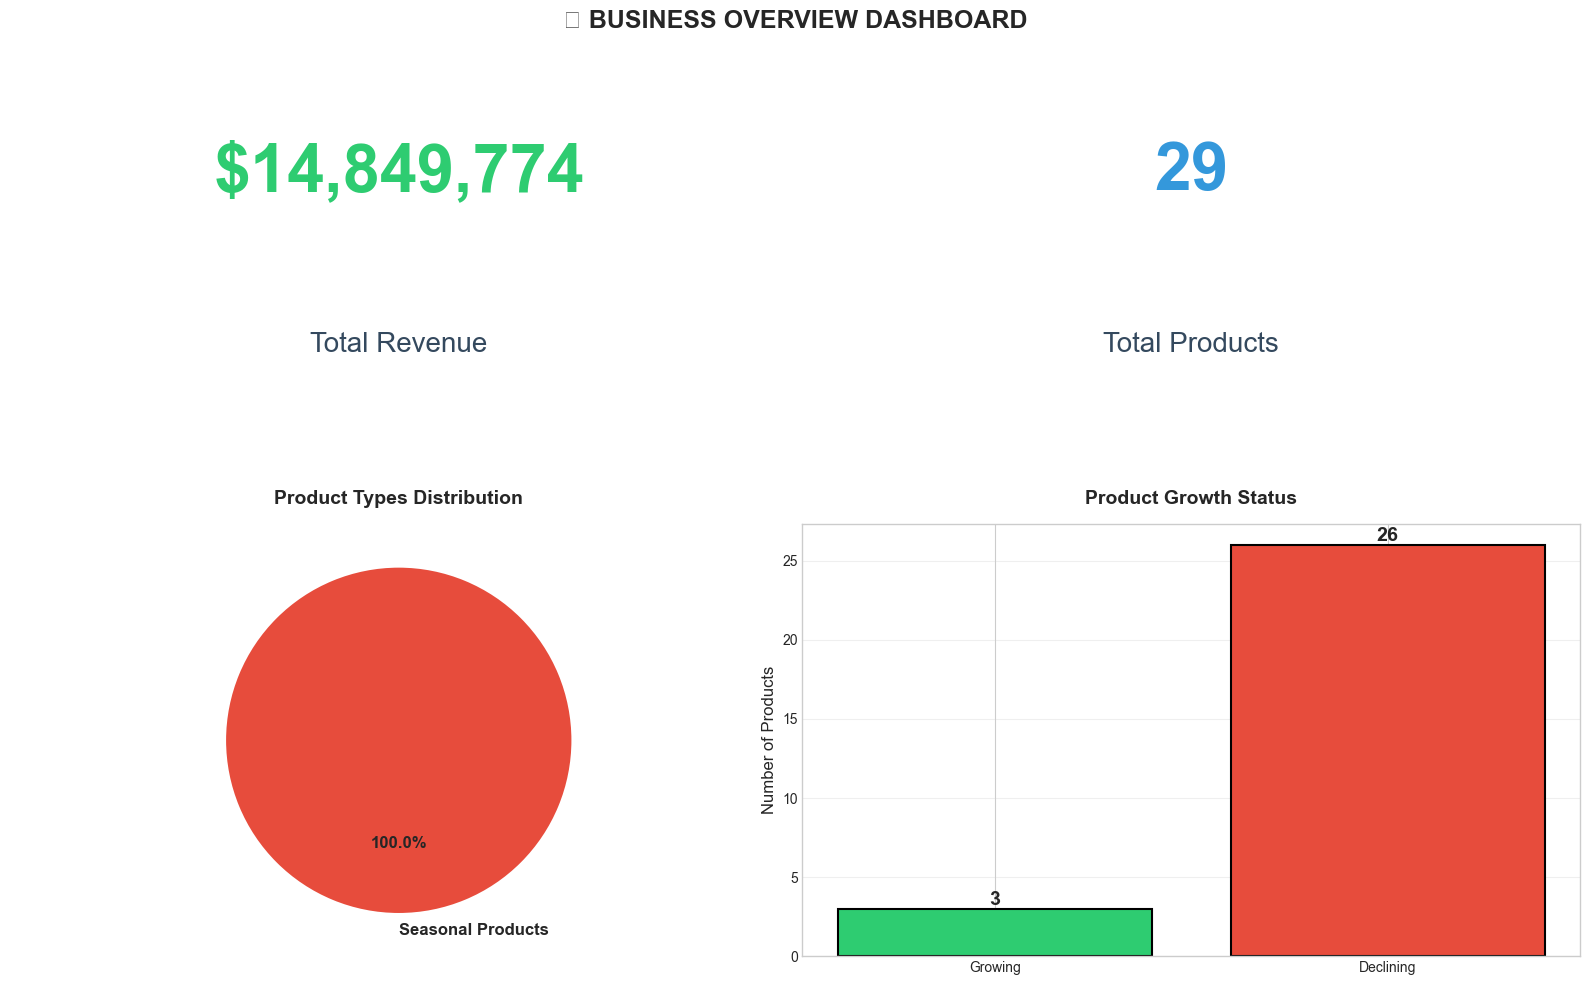


✅ Dashboard 1: Business Overview - Key metrics at a glance
   • Total Revenue: $14,849,774
   • Total Products: 29
   • Seasonal Products: 29 (100.0%)
   • Growing Products: 3 (10.3%)


In [84]:
# VISUAL DASHBOARD: Easy-to-Read Visualizations for Non-Technical Users
print("="*80)
print("📊 VISUAL DASHBOARD - SEASONAL ANALYSIS INSIGHTS")
print("="*80)
print("\n💡 These visualizations make it easy to understand your product performance at a glance\n")

if len(seasonal_analysis_df) > 0:
    # Set up the plotting style for clarity
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # ========== VISUALIZATION 1: Key Metrics Dashboard ==========
    fig1, axes1 = plt.subplots(2, 2, figsize=(16, 10))
    fig1.suptitle('📈 BUSINESS OVERVIEW DASHBOARD', fontsize=18, fontweight='bold', y=0.98)
    
    # Calculate key metrics
    total_revenue = seasonal_analysis_df['total_revenue'].sum()
    total_products = len(seasonal_analysis_df)
    seasonal_count = seasonal_analysis_df['is_seasonal'].sum()
    growing_count = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0])
    avg_revenue = seasonal_analysis_df['total_revenue'].mean()
    
    # 1.1: Total Revenue (Big Number Display)
    ax1 = axes1[0, 0]
    ax1.axis('off')
    ax1.text(0.5, 0.7, f'${total_revenue:,.0f}', ha='center', va='center', 
             fontsize=48, fontweight='bold', color='#2ecc71')
    ax1.text(0.5, 0.3, 'Total Revenue', ha='center', va='center', 
             fontsize=20, color='#34495e')
    
    # 1.2: Total Products
    ax2 = axes1[0, 1]
    ax2.axis('off')
    ax2.text(0.5, 0.7, f'{total_products}', ha='center', va='center', 
             fontsize=48, fontweight='bold', color='#3498db')
    ax2.text(0.5, 0.3, 'Total Products', ha='center', va='center', 
             fontsize=20, color='#34495e')
    
    # 1.3: Seasonal vs Stable Products (Pie Chart)
    ax3 = axes1[1, 0]
    seasonal_labels = []
    seasonal_sizes = []
    seasonal_colors = []
    
    if seasonal_count > 0:
        seasonal_labels.append('Seasonal Products')
        seasonal_sizes.append(seasonal_count)
        seasonal_colors.append('#e74c3c')
    
    stable_count = total_products - seasonal_count
    if stable_count > 0:
        seasonal_labels.append('Stable Products')
        seasonal_sizes.append(stable_count)
        seasonal_colors.append('#3498db')
    
    if len(seasonal_sizes) > 0:
        ax3.pie(seasonal_sizes, labels=seasonal_labels, autopct='%1.1f%%', 
                colors=seasonal_colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
        ax3.set_title('Product Types Distribution', fontsize=14, fontweight='bold', pad=15)
    
    # 1.4: Growth Status (Bar Chart)
    ax4 = axes1[1, 1]
    growing_count = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0])
    declining_count = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] < 0])
    stable_growth_count = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] == 0])
    
    growth_data = []
    growth_labels = []
    growth_colors = []
    
    if growing_count > 0:
        growth_data.append(growing_count)
        growth_labels.append('Growing')
        growth_colors.append('#2ecc71')
    if declining_count > 0:
        growth_data.append(declining_count)
        growth_labels.append('Declining')
        growth_colors.append('#e74c3c')
    if stable_growth_count > 0:
        growth_data.append(stable_growth_count)
        growth_labels.append('Stable')
        growth_colors.append('#95a5a6')
    
    if len(growth_data) > 0:
        bars = ax4.bar(growth_labels, growth_data, color=growth_colors, edgecolor='black', linewidth=1.5)
        ax4.set_title('Product Growth Status', fontsize=14, fontweight='bold', pad=15)
        ax4.set_ylabel('Number of Products', fontsize=12)
        ax4.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Dashboard 1: Business Overview - Key metrics at a glance")
    print(f"   • Total Revenue: ${total_revenue:,.0f}")
    print(f"   • Total Products: {total_products}")
    print(f"   • Seasonal Products: {seasonal_count} ({seasonal_count/total_products*100:.1f}%)")
    print(f"   • Growing Products: {growing_count} ({growing_count/total_products*100:.1f}%)")
    
else:
    print("⚠ No data available for visualization")


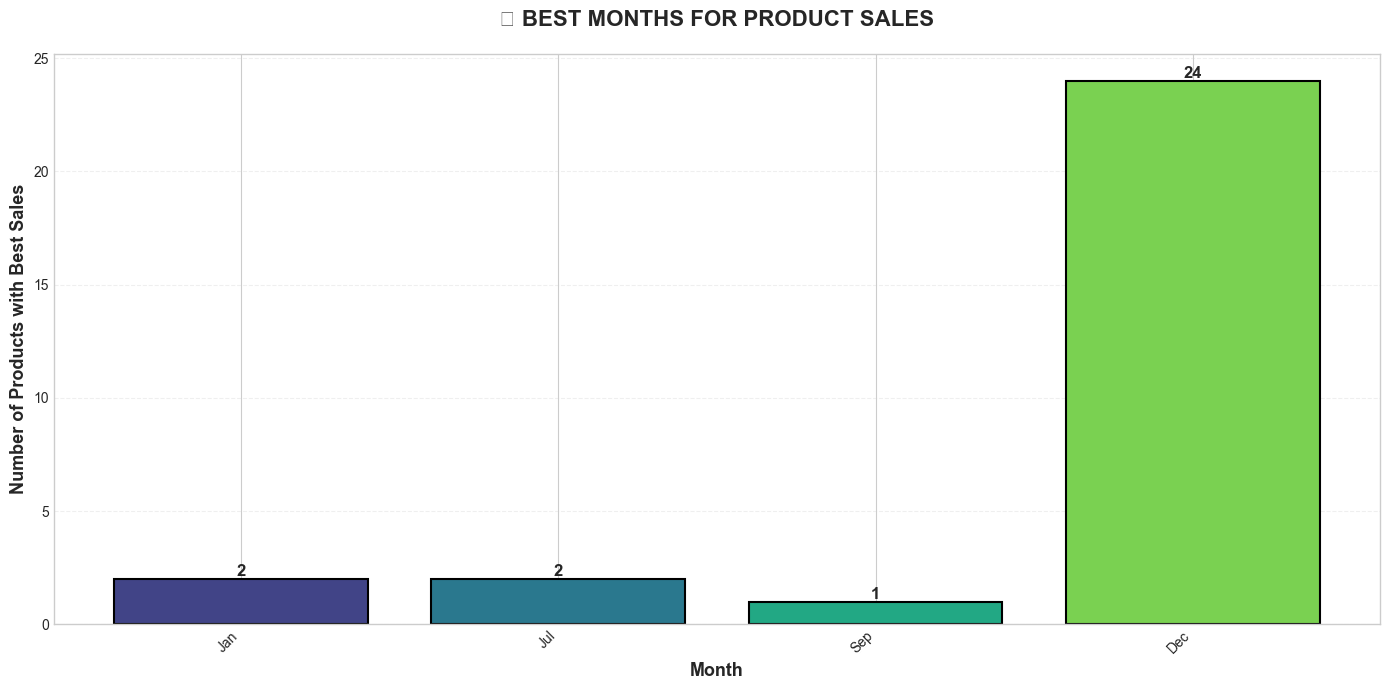


✅ Dashboard 2: Best Sales Months
   • Most products perform best in: Dec
   • 24 products have their peak sales in Dec
   💡 Action: Plan inventory and marketing campaigns 2-3 months before peak months


In [85]:
# ========== VISUALIZATION 2: Best Months for Sales ==========
if len(seasonal_analysis_df) > 0:
    # Count how many products have each month as their best month
    best_month_counts = seasonal_analysis_df['best_month'].value_counts().sort_index()
    best_month_labels = [month_names[int(m)-1] for m in best_month_counts.index]
    
    fig2, ax2 = plt.subplots(figsize=(14, 7))
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(best_month_labels)))
    bars = ax2.bar(best_month_labels, best_month_counts.values, color=colors, edgecolor='black', linewidth=1.5)
    
    ax2.set_title('📅 BEST MONTHS FOR PRODUCT SALES', fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Month', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Number of Products with Best Sales', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Find the most popular best month
    most_popular_month = best_month_labels[best_month_counts.values.argmax()]
    print(f"\n✅ Dashboard 2: Best Sales Months")
    print(f"   • Most products perform best in: {most_popular_month}")
    print(f"   • {best_month_counts.max()} products have their peak sales in {most_popular_month}")
    print(f"   💡 Action: Plan inventory and marketing campaigns 2-3 months before peak months")


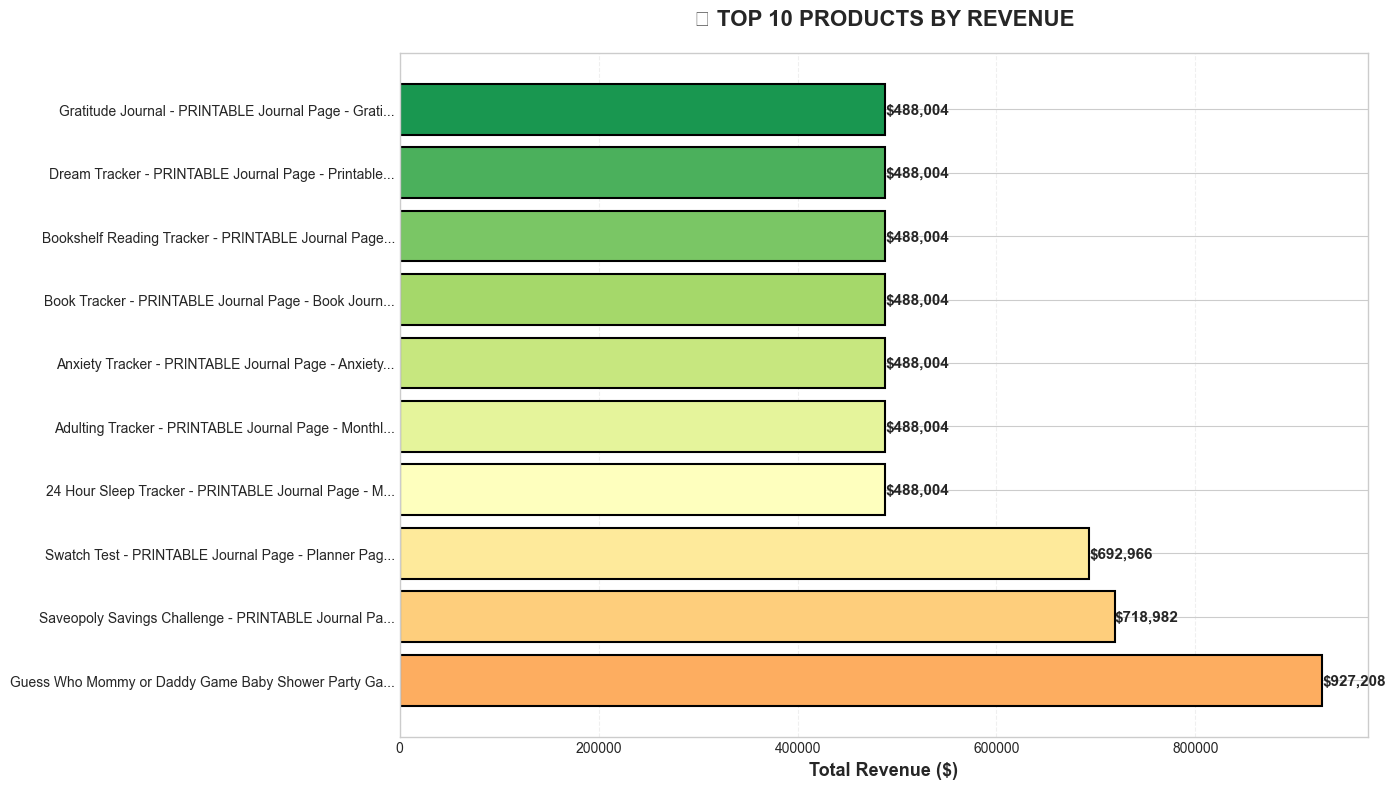


✅ Dashboard 3: Top Revenue Products
   • Top product: Guess Who Mommy or Daddy Game Baby Shower Party Game Mommy o
   • Top 10 products generate: $5,755,183
   • This represents 38.8% of total revenue
   💡 Action: Focus marketing efforts on these high-performing products


In [86]:
# ========== VISUALIZATION 3: Top 10 Products by Revenue ==========
if len(seasonal_analysis_df) > 0:
    top_10 = seasonal_analysis_df.nlargest(10, 'total_revenue')
    
    fig3, ax3 = plt.subplots(figsize=(14, 8))
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_10)))
    bars = ax3.barh(range(len(top_10)), top_10['total_revenue'].values, color=colors, edgecolor='black', linewidth=1.5)
    
    # Truncate long titles for better readability
    titles = [title[:50] + '...' if len(title) > 50 else title for title in top_10['title'].values]
    ax3.set_yticks(range(len(top_10)))
    ax3.set_yticklabels(titles, fontsize=10)
    ax3.set_xlabel('Total Revenue ($)', fontsize=13, fontweight='bold')
    ax3.set_title('💰 TOP 10 PRODUCTS BY REVENUE', fontsize=16, fontweight='bold', pad=20)
    ax3.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_10['total_revenue'].values)):
        ax3.text(value, bar.get_y() + bar.get_height()/2,
                f'${value:,.0f}', ha='left', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    total_revenue_all = seasonal_analysis_df['total_revenue'].sum()
    print(f"\n✅ Dashboard 3: Top Revenue Products")
    print(f"   • Top product: {top_10.iloc[0]['title'][:60]}")
    print(f"   • Top 10 products generate: ${top_10['total_revenue'].sum():,.0f}")
    print(f"   • This represents {top_10['total_revenue'].sum()/total_revenue_all*100:.1f}% of total revenue")
    print(f"   💡 Action: Focus marketing efforts on these high-performing products")


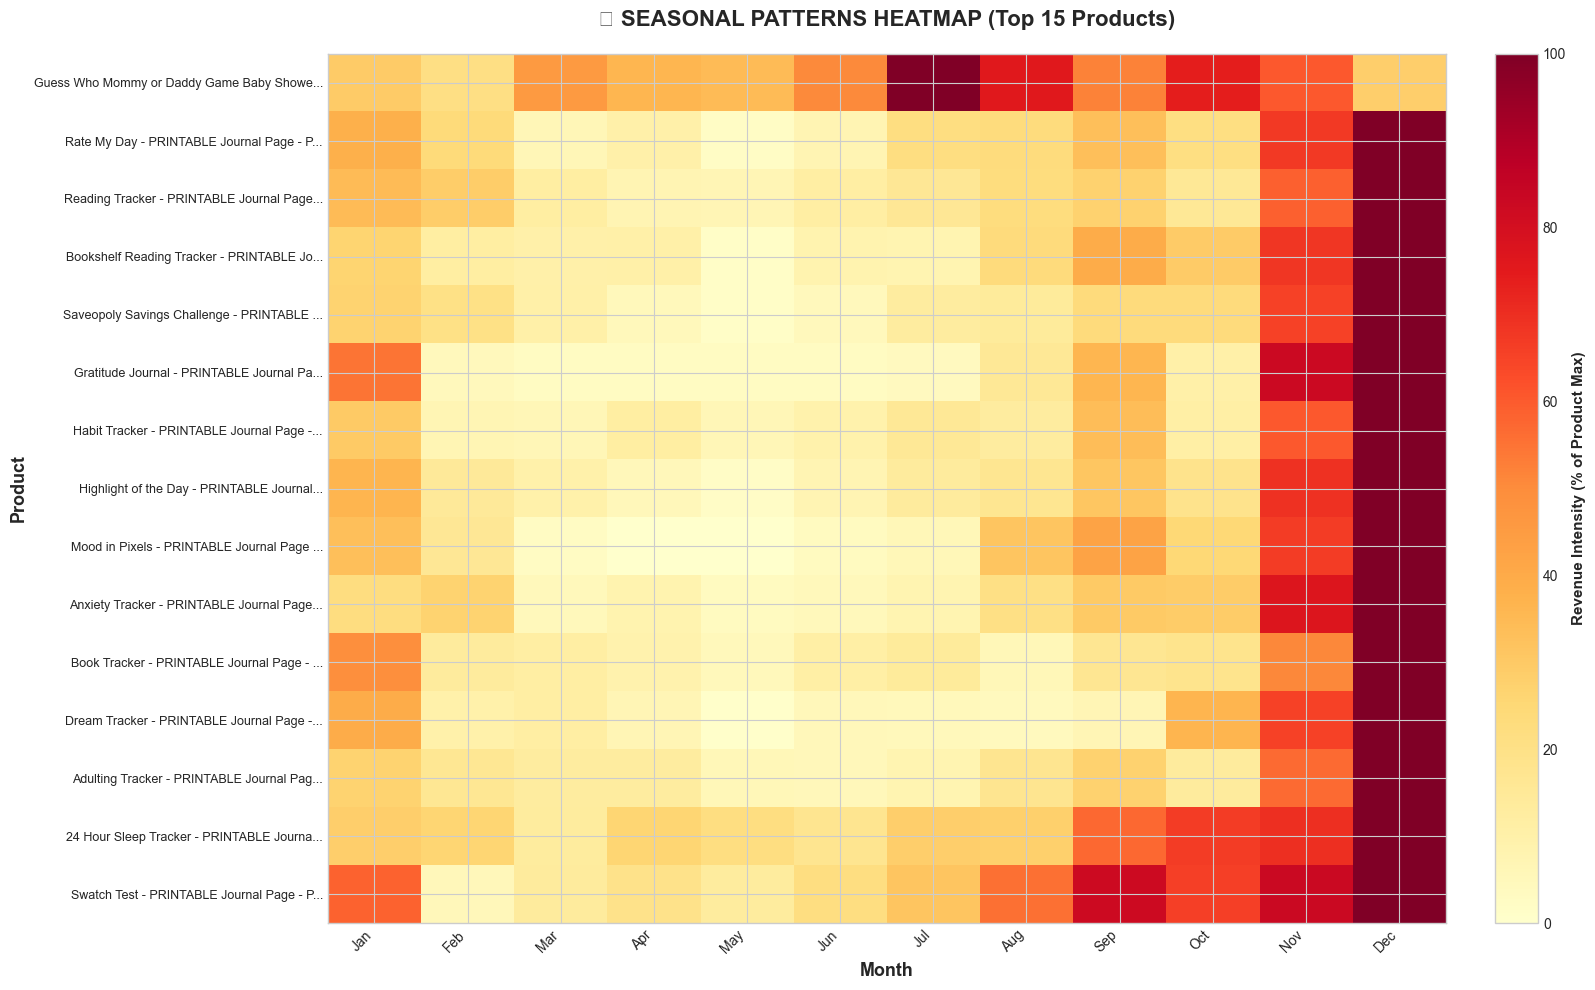


✅ Dashboard 4: Seasonal Patterns Heatmap
   • Shows revenue intensity for top 15 products across all months
   • Darker colors = higher revenue in that month
   💡 Action: Identify which products need inventory planning for specific months


In [87]:
# ========== VISUALIZATION 4: Seasonal Patterns Heatmap ==========
if len(seasonal_analysis_df) > 0 and len(trends_df) > 0:
    # Create a pivot table: products (rows) x months (columns) with revenue values
    monthly_revenue = trends_df.pivot_table(
        index='listing_id', 
        columns='month', 
        values='total_revenue', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Get top 15 products by revenue for readability
    top_15_ids = seasonal_analysis_df.nlargest(15, 'total_revenue')['listing_id'].values
    monthly_revenue_top = monthly_revenue.loc[monthly_revenue.index.isin(top_15_ids)]
    
    # Get product titles for labels
    product_titles = []
    for listing_id in monthly_revenue_top.index:
        title = seasonal_analysis_df[seasonal_analysis_df['listing_id'] == listing_id]['title'].iloc[0]
        product_titles.append(title[:40] + '...' if len(title) > 40 else title)
    
    # Create heatmap
    fig4, ax4 = plt.subplots(figsize=(16, 10))
    
    # Normalize data for better visualization (percentage of max per product)
    monthly_revenue_normalized = monthly_revenue_top.div(monthly_revenue_top.max(axis=1), axis=0) * 100
    
    im = ax4.imshow(monthly_revenue_normalized.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    
    # Set ticks and labels
    ax4.set_xticks(range(12))
    ax4.set_xticklabels(month_names, rotation=45, ha='right')
    ax4.set_yticks(range(len(product_titles)))
    ax4.set_yticklabels(product_titles, fontsize=9)
    
    ax4.set_xlabel('Month', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Product', fontsize=13, fontweight='bold')
    ax4.set_title('🔥 SEASONAL PATTERNS HEATMAP (Top 15 Products)', fontsize=16, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)
    cbar.set_label('Revenue Intensity (% of Product Max)', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Dashboard 4: Seasonal Patterns Heatmap")
    print(f"   • Shows revenue intensity for top 15 products across all months")
    print(f"   • Darker colors = higher revenue in that month")
    print(f"   💡 Action: Identify which products need inventory planning for specific months")


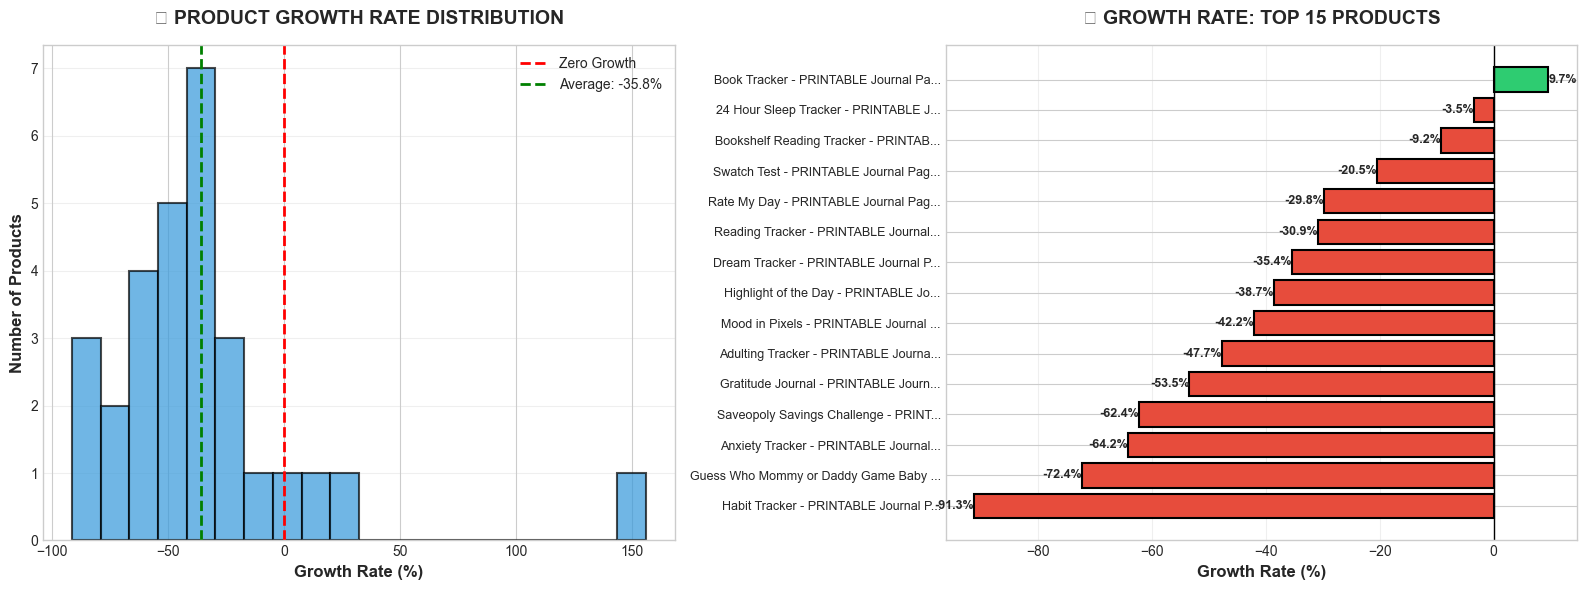


✅ Dashboard 5: Growth Analysis
   • Growing products: 3 (10.3%)
   • Declining products: 26 (89.7%)
   • Average growth rate: -35.8%
   💡 Action: Invest more in growing products, investigate declining ones


In [88]:
# ========== VISUALIZATION 5: Growth Rate Distribution ==========
if len(seasonal_analysis_df) > 0:
    fig5, (ax5a, ax5b) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 5a: Growth Rate Histogram
    growth_rates = seasonal_analysis_df['growth_rate'].values
    ax5a.hist(growth_rates, bins=20, color='#3498db', edgecolor='black', linewidth=1.5, alpha=0.7)
    ax5a.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Growth')
    ax5a.axvline(x=growth_rates.mean(), color='green', linestyle='--', linewidth=2, 
                 label=f'Average: {growth_rates.mean():.1f}%')
    ax5a.set_xlabel('Growth Rate (%)', fontsize=12, fontweight='bold')
    ax5a.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
    ax5a.set_title('📊 PRODUCT GROWTH RATE DISTRIBUTION', fontsize=14, fontweight='bold', pad=15)
    ax5a.legend(fontsize=10)
    ax5a.grid(axis='y', alpha=0.3)
    
    # 5b: Growth Rate by Product (Top 15)
    top_15_growth = seasonal_analysis_df.nlargest(15, 'total_revenue')[['title', 'growth_rate']].sort_values('growth_rate', ascending=True)
    colors_growth = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_15_growth['growth_rate'].values]
    
    titles_short = [title[:35] + '...' if len(title) > 35 else title for title in top_15_growth['title'].values]
    bars = ax5b.barh(range(len(top_15_growth)), top_15_growth['growth_rate'].values, 
                     color=colors_growth, edgecolor='black', linewidth=1.5)
    ax5b.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax5b.set_yticks(range(len(top_15_growth)))
    ax5b.set_yticklabels(titles_short, fontsize=9)
    ax5b.set_xlabel('Growth Rate (%)', fontsize=12, fontweight='bold')
    ax5b.set_title('📈 GROWTH RATE: TOP 15 PRODUCTS', fontsize=14, fontweight='bold', pad=15)
    ax5b.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, top_15_growth['growth_rate'].values)):
        ax5b.text(value, bar.get_y() + bar.get_height()/2,
                 f'{value:.1f}%', ha='left' if value >= 0 else 'right', va='center', 
                 fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    total_products_all = len(seasonal_analysis_df)
    growing = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] > 0])
    declining = len(seasonal_analysis_df[seasonal_analysis_df['growth_rate'] < 0])
    print(f"\n✅ Dashboard 5: Growth Analysis")
    print(f"   • Growing products: {growing} ({growing/total_products_all*100:.1f}%)")
    print(f"   • Declining products: {declining} ({declining/total_products_all*100:.1f}%)")
    print(f"   • Average growth rate: {growth_rates.mean():.1f}%")
    print(f"   💡 Action: Invest more in growing products, investigate declining ones")


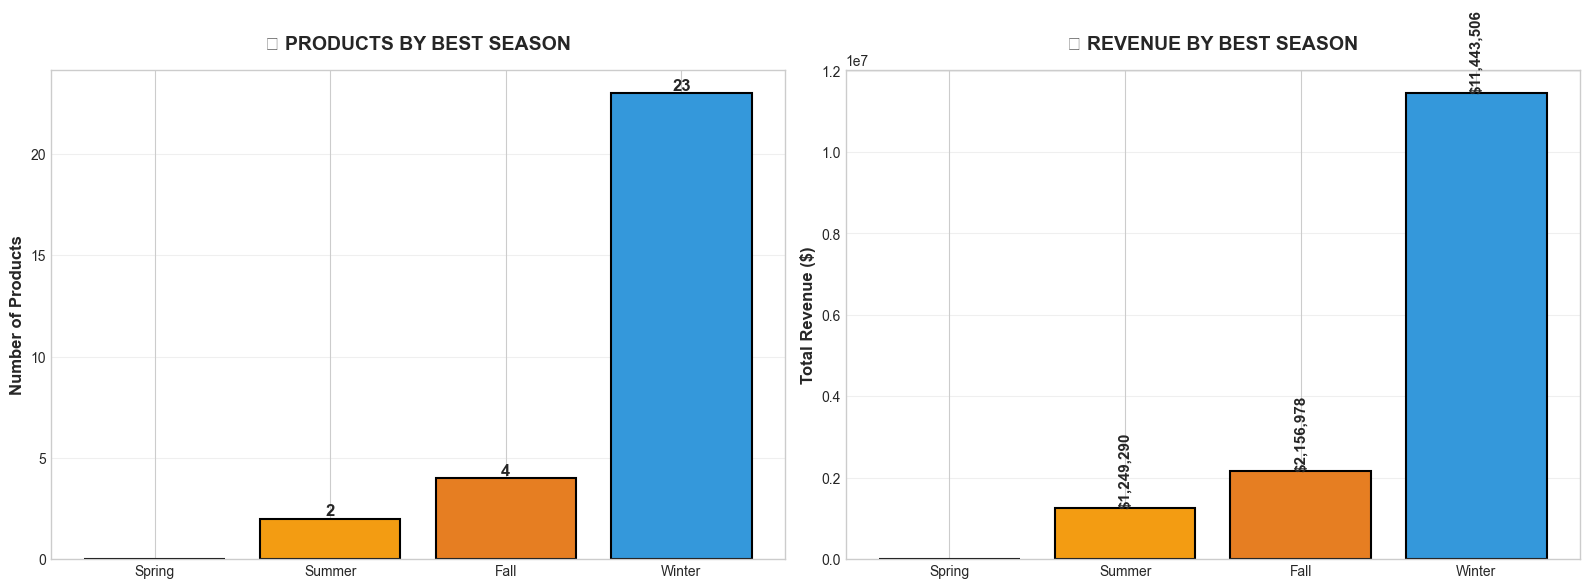


✅ Dashboard 6: Seasonal Performance
   • Most products perform best in: Winter (23 products)
   • Highest revenue season: Winter ($11,443,506)
   💡 Action: Plan inventory and marketing for peak seasons

✅ ALL VISUALIZATIONS COMPLETE!

💡 These visualizations help you:
   • Understand overall business performance at a glance
   • Identify best months and seasons for sales
   • Focus on top-performing products
   • Plan inventory and marketing campaigns effectively
   • Make data-driven decisions without technical expertise


In [89]:
# ========== VISUALIZATION 6: Best Seasons Summary ==========
if len(seasonal_analysis_df) > 0:
    # Count products by best season
    season_counts = seasonal_analysis_df['best_season'].value_counts()
    season_order = ['Spring', 'Summer', 'Fall', 'Winter']
    season_counts_ordered = [season_counts.get(season, 0) for season in season_order]
    
    # Calculate revenue by season
    season_revenue = seasonal_analysis_df.groupby('best_season')['total_revenue'].sum()
    season_revenue_ordered = [season_revenue.get(season, 0) for season in season_order]
    
    fig6, (ax6a, ax6b) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 6a: Number of products by best season
    colors_season = ['#2ecc71', '#f39c12', '#e67e22', '#3498db']
    bars1 = ax6a.bar(season_order, season_counts_ordered, color=colors_season, 
                     edgecolor='black', linewidth=1.5)
    ax6a.set_title('📦 PRODUCTS BY BEST SEASON', fontsize=14, fontweight='bold', pad=15)
    ax6a.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
    ax6a.grid(axis='y', alpha=0.3)
    
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax6a.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 6b: Revenue by best season
    bars2 = ax6b.bar(season_order, season_revenue_ordered, color=colors_season, 
                     edgecolor='black', linewidth=1.5)
    ax6b.set_title('💰 REVENUE BY BEST SEASON', fontsize=14, fontweight='bold', pad=15)
    ax6b.set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
    ax6b.grid(axis='y', alpha=0.3)
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax6b.text(bar.get_x() + bar.get_width()/2., height,
                     f'${height:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold', rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    best_season_count = season_counts.idxmax()
    best_season_revenue = season_revenue.idxmax()
    print(f"\n✅ Dashboard 6: Seasonal Performance")
    print(f"   • Most products perform best in: {best_season_count} ({season_counts.max()} products)")
    print(f"   • Highest revenue season: {best_season_revenue} (${season_revenue.max():,.0f})")
    print(f"   💡 Action: Plan inventory and marketing for peak seasons")
    
    print("\n" + "="*80)
    print("✅ ALL VISUALIZATIONS COMPLETE!")
    print("="*80)
    print("\n💡 These visualizations help you:")
    print("   • Understand overall business performance at a glance")
    print("   • Identify best months and seasons for sales")
    print("   • Focus on top-performing products")
    print("   • Plan inventory and marketing campaigns effectively")
    print("   • Make data-driven decisions without technical expertise")


In [90]:
# Final Summary: All Exported CSV Files
print("="*80)
print("ANALYSIS COMPLETE - ALL FILES EXPORTED")
print("="*80)

print("\n📁 COMPLETE LIST OF EXPORTED CSV FILES:")
print("\n1. Core Analysis Files:")
print("   • product_seasonal_analysis.csv")
print("     → Complete seasonal analysis per product (best months, seasons, variation, growth)")
print("   • product_seasonal_trends_detailed.csv")
print("     → Detailed monthly revenue trends for each product")
print("   • product_monthly_breakdown.csv")
print("     → Monthly revenue breakdown and performance metrics")
print("   • product_seasonal_recommendations.csv")
print("     → Actionable recommendations per product based on seasonal patterns")

print("\n2. Advanced Analysis Files:")
print("   • comprehensive_seasonal_summary.csv")
print("     → Strategic summary with all key metrics and risk indicators")
print("   • product_volatility_analysis.csv")
print("     → Revenue volatility and stability metrics per product")
print("   • optimal_launch_timing.csv")
print("     → Best months to launch new products based on historical patterns")
print("   • product_seasonal_momentum.csv")
print("     → Seasonal momentum trends (strengthening/weakening seasonality)")
print("   • product_peak_duration.csv")
print("     → Peak season duration and recovery time analysis")

print("\n💡 USAGE RECOMMENDATIONS:")
print("   • Use 'product_seasonal_recommendations.csv' for quick action items")
print("   • Use 'comprehensive_seasonal_summary.csv' for strategic planning")
print("   • Use 'product_seasonal_analysis.csv' for detailed product insights")
print("   • Use 'optimal_launch_timing.csv' for new product planning")

print("\n✅ All seasonal analysis data has been exported and is ready for use!")
print("   Files are saved in the current working directory.")


ANALYSIS COMPLETE - ALL FILES EXPORTED

📁 COMPLETE LIST OF EXPORTED CSV FILES:

1. Core Analysis Files:
   • product_seasonal_analysis.csv
     → Complete seasonal analysis per product (best months, seasons, variation, growth)
   • product_seasonal_trends_detailed.csv
     → Detailed monthly revenue trends for each product
   • product_monthly_breakdown.csv
     → Monthly revenue breakdown and performance metrics
   • product_seasonal_recommendations.csv
     → Actionable recommendations per product based on seasonal patterns

2. Advanced Analysis Files:
   • comprehensive_seasonal_summary.csv
     → Strategic summary with all key metrics and risk indicators
   • product_volatility_analysis.csv
     → Revenue volatility and stability metrics per product
   • optimal_launch_timing.csv
     → Best months to launch new products based on historical patterns
   • product_seasonal_momentum.csv
     → Seasonal momentum trends (strengthening/weakening seasonality)
   • product_peak_duration.cs